# Práctica Final Gestión del Riesgo de Crédito

###  Autores: Lucía Saiz Lapique y Miguel López Garralón

__Contacto:__ l.saiz@cunef.edu, m.lopez@cunef.edu

__Asignatura:__ Gestión del Riesgo de Crédito

__Máster en Data Science y Finanzas, CUNEF__

__Versión:__ 1.0

## Índice

1.  [Introducción y objetivo](#Introducción-y-objetivo:) 
2.  [Metodología](#Metodología:)
3.  [Selección Target Variable](#Selección-Target-Variable)
4.  [Análisis Exploratorio de los Datos (EDA)](#Análisis-Exploratorio-de-los-Datos-(EDA))
    - [Eliminar duplicados](#Eliminar-duplicados)
    - [Ingeniería de variables](#Ingeniería-de-variables)
        - Cración de variables numéricas
        - Imputar valores nulos
        - Creación de variables dicotómicas
        - Cambiar tipo de variables
        - Eliminar variables
    - [Estudio variables numéricas](#Estudiamos-variables-numéricas)
        - Estudio estadístico
        - Histogramas
        - Matriz de correlaciones
            - Eliminación variables muy correlacionadas
        - Escalado 
    - [Estudio variables categóricas](#Estudiamos-variables-categóricas)
        - Estudio estadístico
        - Distribución de las variables y comparación con target
        - Explicación no dummies
6.  [PCA](#PCA)
7.  [División en train y test](#División-en-train-y-test)
8.  [Tratar desequilibrio (SMOTETomek)](#Tratamiento-de-desequilibrio-(SmoteTomek))
9.  [Feature Importance (Random Forest)](#Feature-Importance-(Random-Forest))
10.  [Modelos y métricas](#Modelos)
    - Support Vector Machine (SVM)
    - Logística
    - Gradient Boosting Classifier
    - Adaboost
    - Random Forest
    - Mejor modelo
        - Validación por Bootstrapping
12.  [Matriz de costes para mejor modelo (Random Forest)](#Cut-off-óptimo-(matriz-de-costes))
13.  [Conclusiones](#Conclusiones)
14.  [Bibliografía](#Bibliografía)

## Introducción y objetivo:

Tras la crisis de 2008 y debido a los impagos que surgieron, consideramos que la pérdida generada por los créditos concedidos a clientes que no van a pagar son mayores que los ingresos que dejamos de recibir de clientes buenos a los que no se les concede el préstamo (por una mala identificación por parte del modelo, es decir, falsos positivos). 

El objetivo del estudio a continuación es identificar los clientes que no van a pagar el préstamo concedido en base a los datos históricos proporcionados. Se aplicará una penalización mayor a los casos que el modelo identifique como buenos pero que realmente son malos (impagos) frente a los que identifique como malos pero realmente son buenos. La intención es aumentar el recall de la clase minoritaria (malos), aunque suponga perder clientes buenos, ya que las pérdidas serán menores. 

__Librerías__

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

register_matplotlib_converters()
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # estandarization
from sklearn import preprocessing # estandarization
from sklearn.model_selection import train_test_split

from datetime import datetime
import ppscore as pps
import seaborn as sns

from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Log Regression
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve # ROC Curve
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler # estandarization
from sklearn import preprocessing # estandarization
from sklearn.model_selection import train_test_split # split data
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler # estandarization
from sklearn import preprocessing # estandarization
import xgboost as xgb # XGBOOST
import pickle

from math import sqrt # sqrt
import itertools # aplanar arrays
import math

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.decomposition import PCA

import random

pd.set_option('display.max_columns', None)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Luli\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Luli\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.2

__Lectura de datos__

In [2]:
datos = pd.read_csv("data_project.csv",sep=";", decimal = ',')
datos.head()

,id_customer,amount_initial,open_date,age_business,client_date,age_owner_se,SECTOR,def_30dpd_12m,def_30dpd_6m,def_30dpd_9m,def_60dpd_12m,def_60dpd_6m,def_60dpd_9m,def_90dpd_12m,def_90dpd_6m,def_90dpd_9m,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,sum_amountused,inf_profit_loss,inf_revenue,inf_roa,inf_roe,days_back,client_date_segm_1,num_owners,Amt_sum_tr2,Amt_sum_slope,Min_Flog,Mean_tr3,Max_mode_tr4,Amt_sum_m3,Cat_famount,Famount_tr5,Famount_tr6,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Max_tr11,Mean_tr11
0,1,35200,13/12/2015,20.0,02/11/2012,NaN,1017,0,0,0,0,0,0,0,0,0,NaN,5.0,1001,1,1071680.0,46.0,NaN,12828.42,154850.70,11.34,24.15,66.0,02/11/2012,2.0,7268.0,689155.0,NaN,4450.0,NaN,3288200.0,6762.0,0.0,0.0,0.315789,20059.0,5853.0,582696.0,350000.0,2821.0,NaN,NaN
1,2,9000,20/12/2015,20.0,02/11/2012,NaN,1017,0,0,0,0,0,0,0,0,0,NaN,5.0,1001,1,1212643.0,46.0,NaN,12828.42,154850.70,11.34,24.15,73.0,02/11/2012,2.0,39420.0,819471.0,NaN,11797.0,NaN,5248290.0,5121.0,0.0,0.0,0.338710,21869.0,17677.0,824454.0,500000.0,2821.0,NaN,NaN
2,3,4000,17/12/2015,NaN,14/09/2013,25.0,1001,0,0,0,0,0,0,0,0,0,2.0,NaN,2,1000,359152.0,NaN,106000.0,NaN,NaN,NaN,NaN,20.0,06/10/2014,NaN,13461.0,-17178.0,NaN,NaN,1598.0,936503.0,4221.0,0.0,0.0,3.550000,NaN,NaN,26380.0,9035.0,1092.0,1598.0,1521.0
3,4,6300,18/12/2015,3.0,08/01/2014,NaN,1023,0,0,0,0,0,0,0,0,0,1.0,4.0,1000,1,308335.0,45.0,32000.0,12117.85,249035.17,5.77,7.30,35.0,08/01/2014,2.0,12431.0,-324101.0,NaN,5243.0,250000.0,3780758.0,7807.0,0.0,0.0,1.685714,8119.0,46244.0,134238.0,100000.0,1000.0,250000.0,250000.0
4,5,9000,16/12/2015,1.0,26/04/2014,NaN,1031,0,0,0,0,0,0,0,0,0,NaN,NaN,1000,1,522587.0,34.0,NaN,NaN,NaN,NaN,NaN,85.0,26/04/2014,1.0,12959.0,-234496.0,NaN,30971.0,66076.0,-175062.0,0.0,0.0,0.0,0.460674,2524.0,1841.0,64328.0,38155.0,3311.0,66076.0,41458.0


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8555 entries, 0 to 8554
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_customer         8555 non-null   int64  
 1   amount_initial      8555 non-null   int64  
 2   open_date           8555 non-null   object 
 3   age_business        8343 non-null   float64
 4   client_date         8555 non-null   object 
 5   age_owner_se        4540 non-null   float64
 6   SECTOR              8555 non-null   int64  
 7   def_30dpd_12m       8555 non-null   int64  
 8   def_30dpd_6m        8555 non-null   int64  
 9   def_30dpd_9m        8555 non-null   int64  
 10  def_60dpd_12m       8555 non-null   int64  
 11  def_60dpd_6m        8555 non-null   int64  
 12  def_60dpd_9m        8555 non-null   int64  
 13  def_90dpd_12m       8555 non-null   int64  
 14  def_90dpd_6m        8555 non-null   int64  
 15  def_90dpd_9m        8555 non-null   int64  
 16  n_prod

## Metodología:

En el estudio a continuación, vamos a crear un scorecard para medir el riesgo crediticio de 8555 empresas de emprendedores (KGB population) con distintas característica propias (47). Estas características son tanto de tipo sociodemográfico, como por ejemplo la edad de los emprendedores, el sector de trabajo, ratios financieros y balances internos, etc., como de relación con la entidad (años siendo cliente, retrasos en el pago en distintos periodos, etc.). Se observa que hay 44 variables numéricas y 3 categóricas. Sin embargo, se ha podido comprobar que el tipo de alguna de las variables no es el correcto, habiendo más categóricas de las que realmente aparecen, incluidas algunas con formato de fecha. Esto se tratará más adelante.

Para cumplir con el objetivo establecido, en primer lugar debemos seleccionar la variable objetivo que vamos a considerar como 'malo'. Tras esto, se preparará la base de datos para eliminar valores nulos y facilitar al modelo la clasificación de los clientes en buenos y malos. Una vez tengamos la base de datos final, se seleccionarán las variables que sean más relevantes para la predicción de la parte de test y se probarán una serie de modelos de clasificación para ver cuáles tienen los mejores resultados. 

## Selección Target Variable

Debido a que el dataset proporcionado cuenta con una población de tipo Known-Good-Bad, se debe seleccionar la ventana de comportamiento que deseamos estudiar y los días que consideramos como impago. Existen 9 variables que pueden ser seleccionadas como el target, a continuación realizamos un análisis en profundidad para decidir cuál de ellas será considerada finalmente como tal. Los pasos llevados a cabo son los siguientes:

- Observar porcentaje de malos por cada variable y por meses
- Decidir si se considera malos los que llevan 30, 60 o 90 días sin pagar
- Comparación de porcentaje de malos en función de la ventana de comportamiento (6, 9 o 12 meses)

In [4]:
target_var = datos.iloc[:, 7:16]
target_var

,def_30dpd_12m,def_30dpd_6m,def_30dpd_9m,def_60dpd_12m,def_60dpd_6m,def_60dpd_9m,def_90dpd_12m,def_90dpd_6m,def_90dpd_9m
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8550,0,0,0,0,0,0,0,0,0
8551,1,1,1,1,0,1,0,0,0
8552,0,0,0,0,0,0,0,0,0
8553,0,0,0,0,0,0,0,0,0


Mostramos el porcentaje de casos sobre el total de la muestra que serían considerados malos por cada variable. Observamos que la variable que más porcentaje de retraso de pagos (1) que tiene es la de 30 días en una ventana de 12 meses, pero consideramos que son muy pocos días para considerarlos 'malos'. 

In [5]:
target_var.sum()/len(target_var)*100

def_30dpd_12m    8.883694
def_30dpd_6m     5.704267
def_30dpd_9m     7.855056
def_60dpd_12m    7.200468
def_60dpd_6m     3.798948
def_60dpd_9m     6.043250
def_90dpd_12m    6.019871
def_90dpd_6m     2.735243
def_90dpd_9m     4.850964
dtype: float64

### Porcentaje de malos por meses en función de cada variable

In [6]:
target_var['Year'] = pd.to_datetime(datos.open_date.str[3:10])
tabla = pd.DataFrame(target_var.groupby(['Year']).sum()/len(target_var)*100)

Generamos a continuación un gráfico para cada ventana de comportamiento, comparando los tres tipos de retraso en las cuotas para medir la distribución de impagos en cada una; con esto se seleccionará el target final.

#### Porcentaje de malos a 30, 60 y 90 días de impago con ventana de comportamiento de 6 meses

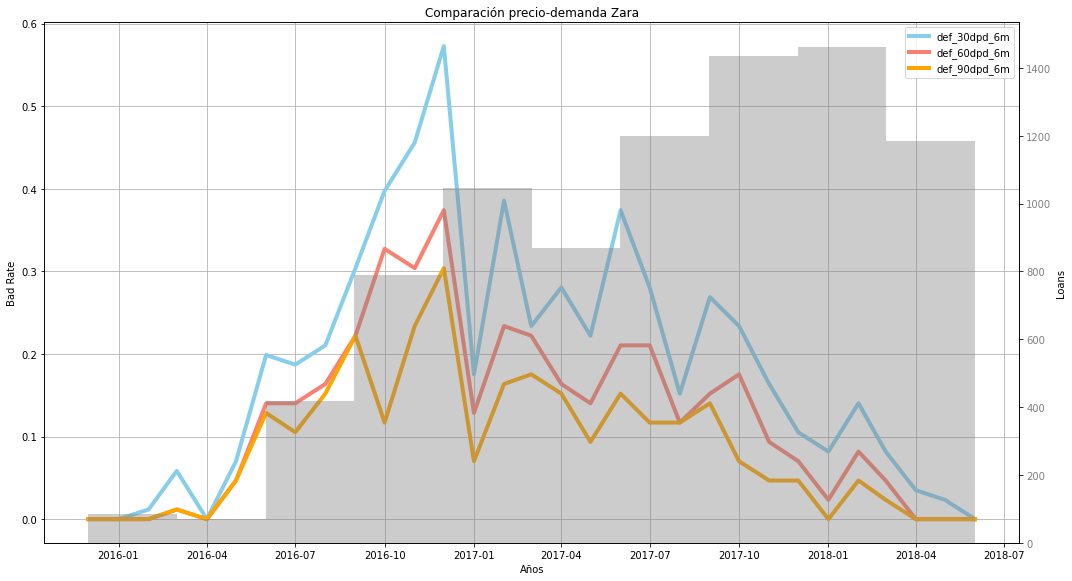

In [7]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Años')
ax1.set_ylabel('Bad Rate', color='black')
ax1.plot(tabla.index, tabla.def_30dpd_6m, marker='', markerfacecolor='skyblue', markersize=12, color='skyblue', 
         linewidth=4, label = tabla.columns[1])
ax1.plot(tabla.index, tabla.def_60dpd_6m, marker='', markerfacecolor='salmon', markersize=12, color='salmon', 
         linewidth=4, label = tabla.columns[4])
ax1.plot(tabla.index, tabla.def_90dpd_6m, marker='', markerfacecolor='orange', markersize=12, color='orange', 
         linewidth=4, label = tabla.columns[7])
ax1.legend()

ax2 = ax1.twinx()  

ax2.set_ylabel('Loans', color='black')
ax2.hist(pd.to_datetime(datos.open_date.str[3:10]), color='gray', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='gray')
ax1.grid(True)

fig.tight_layout()  
plt.title('Comparación precio-demanda Zara')
plt.show()

#### Porcentaje de malos a 30, 60 y 90 días de impago con ventana de comportamiento de 9 meses

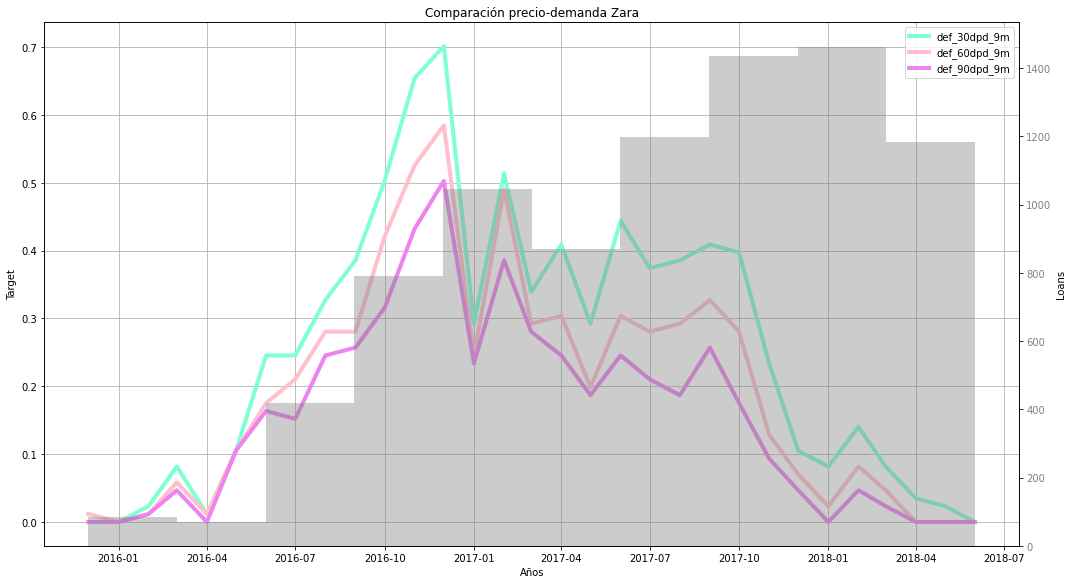

In [8]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Años')
ax1.set_ylabel('Target', color='black')
ax1.plot(tabla.index, tabla.def_30dpd_9m, marker='', markerfacecolor='aquamarine', markersize=12, color='aquamarine',
         linewidth=4, label = tabla.columns[2])
ax1.plot(tabla.index, tabla.def_60dpd_9m, marker='', markerfacecolor='pink', markersize=12, color='pink', 
                  linewidth=4, label = tabla.columns[5])
ax1.plot(tabla.index, tabla.def_90dpd_9m, marker='', markerfacecolor='violet', markersize=12, color='violet', 
                  linewidth=4, label = tabla.columns[8])
ax1.legend()

ax2 = ax1.twinx()  
ax1.grid()
ax2.set_ylabel('Loans', color='black')
ax2.hist(pd.to_datetime(datos.open_date.str[3:10]), color='gray', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()  
plt.title('Comparación precio-demanda Zara')
plt.show()

#### Porcentaje de malos a 30, 60 y 90 días de impago con ventana de comportamiento de 12 meses

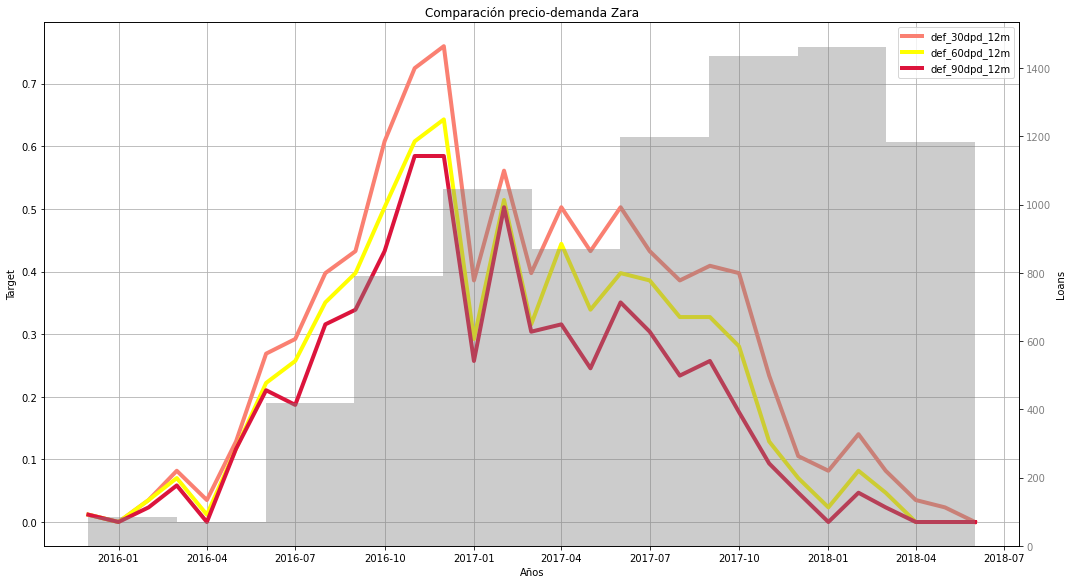

In [9]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Años')
ax1.set_ylabel('Target', color='black')
ax1.plot(tabla.index, tabla.def_30dpd_12m, marker='', markerfacecolor='salmon', markersize=12, color='salmon', 
         linewidth=4, label = tabla.columns[0])
ax1.plot(tabla.index, tabla.def_60dpd_12m, marker='', markerfacecolor='yellow', markersize=12, color='yellow', 
                  linewidth=4, label = tabla.columns[3])
ax1.plot(tabla.index, tabla.def_90dpd_12m, marker='', markerfacecolor='crimson', markersize=12, color='crimson', 
                  linewidth=4, label = tabla.columns[6])
ax1.legend()

ax2 = ax1.twinx()  
ax1.grid(True)
ax2.set_ylabel('Loans', color='black')
ax2.hist(pd.to_datetime(datos.open_date.str[3:10]), color='gray', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='gray')

fig.tight_layout()  
plt.title('Comparación precio-demanda Zara')
plt.show()

Seleccionamos como target la variable __def_90dpd_12m__ (past due de 90 días y performance window de 12 meses):
* __90  días__: Según Basilea II, “Default” es aquella cuenta que alcanza más de 90 días consecutivos en impago. Además, como podemos observar en los gráficos, la distribución de los malos es mucho más constante que la de 30 y 60 días. Consideramos que a 30 y 60 días no sabemos si son realmente malos, así que serán analizados como indeterminados y sacados de la muestra.
* __12 meses__: Comparando el porcentaje de impagos en cada ventana muestral para el número de días seleccionado, en la ventana de 12 meses es mucho mayor que para la de 6 y 9 meses, lo cual nos interesa para que la base de datos no esté desequilibrada.

Observamos que el porcentaje de malos y el número de créditos concedidos desde la primera fecha hasta junio de 2016 es muy inferior al resto de la muestra, por lo que no se considerarán en el estudio. En este mismo sentido y aunque el número de créditos concedidos sea muy superior desde diciembre de 2017, como el ratio de impagos desciende drásticamente, se eliminar esta parte de la muestra también. 

A continuación, nombramos la variable seleccionada como target y agrupamos los datos que hemos considerado como indeterminados en una misma variable para su posterior extración de la muestra. El resto de observaciones se considerarán como buenas. 

In [10]:
datos['Target'] = datos.def_90dpd_12m
datos['Indeterminate'] =  np.where(((datos.def_30dpd_12m == 1) | (datos.def_60dpd_12m == 1)) & (datos.Target != 1), 1, 0)
datos['Good'] = np.where((datos.Target == 1) | (datos.Indeterminate == 1), 0, 1)

In [11]:
datos.drop(datos.iloc[:,7:16], axis = 1, inplace = True)

In [12]:
datos.head()

,id_customer,amount_initial,open_date,age_business,client_date,age_owner_se,SECTOR,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,sum_amountused,inf_profit_loss,inf_revenue,inf_roa,inf_roe,days_back,client_date_segm_1,num_owners,Amt_sum_tr2,Amt_sum_slope,Min_Flog,Mean_tr3,Max_mode_tr4,Amt_sum_m3,Cat_famount,Famount_tr5,Famount_tr6,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Max_tr11,Mean_tr11,Target,Indeterminate,Good
0,1,35200,13/12/2015,20.0,02/11/2012,NaN,1017,NaN,5.0,1001,1,1071680.0,46.0,NaN,12828.42,154850.70,11.34,24.15,66.0,02/11/2012,2.0,7268.0,689155.0,NaN,4450.0,NaN,3288200.0,6762.0,0.0,0.0,0.315789,20059.0,5853.0,582696.0,350000.0,2821.0,NaN,NaN,0,0,1
1,2,9000,20/12/2015,20.0,02/11/2012,NaN,1017,NaN,5.0,1001,1,1212643.0,46.0,NaN,12828.42,154850.70,11.34,24.15,73.0,02/11/2012,2.0,39420.0,819471.0,NaN,11797.0,NaN,5248290.0,5121.0,0.0,0.0,0.338710,21869.0,17677.0,824454.0,500000.0,2821.0,NaN,NaN,0,0,1
2,3,4000,17/12/2015,NaN,14/09/2013,25.0,1001,2.0,NaN,2,1000,359152.0,NaN,106000.0,NaN,NaN,NaN,NaN,20.0,06/10/2014,NaN,13461.0,-17178.0,NaN,NaN,1598.0,936503.0,4221.0,0.0,0.0,3.550000,NaN,NaN,26380.0,9035.0,1092.0,1598.0,1521.0,0,0,1
3,4,6300,18/12/2015,3.0,08/01/2014,NaN,1023,1.0,4.0,1000,1,308335.0,45.0,32000.0,12117.85,249035.17,5.77,7.30,35.0,08/01/2014,2.0,12431.0,-324101.0,NaN,5243.0,250000.0,3780758.0,7807.0,0.0,0.0,1.685714,8119.0,46244.0,134238.0,100000.0,1000.0,250000.0,250000.0,0,0,1
4,5,9000,16/12/2015,1.0,26/04/2014,NaN,1031,NaN,NaN,1000,1,522587.0,34.0,NaN,NaN,NaN,NaN,NaN,85.0,26/04/2014,1.0,12959.0,-234496.0,NaN,30971.0,66076.0,-175062.0,0.0,0.0,0.0,0.460674,2524.0,1841.0,64328.0,38155.0,3311.0,66076.0,41458.0,0,0,1


Comprobamos que se ha agrupado correctamente y confirmamos que el porcentaje de indeterminados es menor a 10%, así que se pueden eliminar de la base de datos

In [13]:
ratios = pd.DataFrame(datos.groupby(['Target', 'Indeterminate', 'Good']).size())
ratios['pct'] = ratios[0]/ratios[0].sum()
ratios

0       pct
Target Indeterminate Good                
0      0             1     7795  0.911163
       1             0      245  0.028638
1      0             0      515  0.060199

In [14]:
## eliminamos los indeterminados
datos = datos[datos['Indeterminate'] == 0]
datos.Indeterminate.sum()

0

In [15]:
datos.pop('Indeterminate')
datos.pop('Good')
datos.head()

,id_customer,amount_initial,open_date,age_business,client_date,age_owner_se,SECTOR,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,sum_amountused,inf_profit_loss,inf_revenue,inf_roa,inf_roe,days_back,client_date_segm_1,num_owners,Amt_sum_tr2,Amt_sum_slope,Min_Flog,Mean_tr3,Max_mode_tr4,Amt_sum_m3,Cat_famount,Famount_tr5,Famount_tr6,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Max_tr11,Mean_tr11,Target
0,1,35200,13/12/2015,20.0,02/11/2012,NaN,1017,NaN,5.0,1001,1,1071680.0,46.0,NaN,12828.42,154850.70,11.34,24.15,66.0,02/11/2012,2.0,7268.0,689155.0,NaN,4450.0,NaN,3288200.0,6762.0,0.0,0.0,0.315789,20059.0,5853.0,582696.0,350000.0,2821.0,NaN,NaN,0
1,2,9000,20/12/2015,20.0,02/11/2012,NaN,1017,NaN,5.0,1001,1,1212643.0,46.0,NaN,12828.42,154850.70,11.34,24.15,73.0,02/11/2012,2.0,39420.0,819471.0,NaN,11797.0,NaN,5248290.0,5121.0,0.0,0.0,0.338710,21869.0,17677.0,824454.0,500000.0,2821.0,NaN,NaN,0
2,3,4000,17/12/2015,NaN,14/09/2013,25.0,1001,2.0,NaN,2,1000,359152.0,NaN,106000.0,NaN,NaN,NaN,NaN,20.0,06/10/2014,NaN,13461.0,-17178.0,NaN,NaN,1598.0,936503.0,4221.0,0.0,0.0,3.550000,NaN,NaN,26380.0,9035.0,1092.0,1598.0,1521.0,0
3,4,6300,18/12/2015,3.0,08/01/2014,NaN,1023,1.0,4.0,1000,1,308335.0,45.0,32000.0,12117.85,249035.17,5.77,7.30,35.0,08/01/2014,2.0,12431.0,-324101.0,NaN,5243.0,250000.0,3780758.0,7807.0,0.0,0.0,1.685714,8119.0,46244.0,134238.0,100000.0,1000.0,250000.0,250000.0,0
4,5,9000,16/12/2015,1.0,26/04/2014,NaN,1031,NaN,NaN,1000,1,522587.0,34.0,NaN,NaN,NaN,NaN,NaN,85.0,26/04/2014,1.0,12959.0,-234496.0,NaN,30971.0,66076.0,-175062.0,0.0,0.0,0.0,0.460674,2524.0,1841.0,64328.0,38155.0,3311.0,66076.0,41458.0,0


## Análisis Exploratorio de los Datos (EDA)

### Creación de dos nuevas variables

Se realiza esta operación aquí ya que son dos variables que se crean mediante el uso de fechas y en el siguiente paso cambiamos el tipo de la variable. Consideramos que las variables de fecha no se pueden tener en cuenta en el modelo como categóricas, pero aportan información relevante teniendo en cuenta los meses que llevan siendo clientes del banco o que el crédito lleva concedido. Por ello, en vez de considerar la fecha completa, se crean dos nuevas variables numéricas con el número de meses en cada una. 

In [16]:
date_format = "%d/%m/%Y"
b = datetime.strptime('01/12/2017', date_format) # última fecha

In [17]:
datos['Num_Months_Open'] = datos.open_date.apply(lambda x: (b - datetime.strptime(x, date_format)).days/30)
datos['Num_Months_Open'] = datos.Num_Months_Open.round()

In [18]:
datos['Num_Months_Client'] = datos.client_date.apply(lambda x: (b - datetime.strptime(x, date_format)).days/30)
datos['Num_Months_Client'] = datos.Num_Months_Client.round()

Reducimos la muestra como se explicó anteriormente. 

In [19]:
datos.open_date = pd.to_datetime(datos.open_date, format = '%d/%m/%Y')

In [20]:
observacion = (datos.open_date < datetime(2017, 12, 1)) & (datos.open_date >= datetime(2016, 6, 1))
datos = datos[(observacion)]

In [21]:
datos.head()

,id_customer,amount_initial,open_date,age_business,client_date,age_owner_se,SECTOR,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,sum_amountused,inf_profit_loss,inf_revenue,inf_roa,inf_roe,days_back,client_date_segm_1,num_owners,Amt_sum_tr2,Amt_sum_slope,Min_Flog,Mean_tr3,Max_mode_tr4,Amt_sum_m3,Cat_famount,Famount_tr5,Famount_tr6,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Max_tr11,Mean_tr11,Target,Num_Months_Open,Num_Months_Client
140,141,6000,2016-06-18,15.0,01/08/2000,36.0,1031,NaN,NaN,2,1004,311003.0,NaN,NaN,NaN,NaN,NaN,NaN,88.0,05/04/2016,NaN,5155.0,3873.0,NaN,12822793.0,60000.0,-129476.0,844.0,0.0,0.0,0.697674,5452.0,11385.0,52944.0,7213.0,37.0,60000.0,60000.0,0,18.0,211.0
141,142,7500,2016-06-24,2.0,13/09/2000,40.0,1029,NaN,NaN,2,1004,217876.0,NaN,NaN,NaN,NaN,NaN,NaN,55.0,22/04/2014,NaN,44020.0,-70802.0,NaN,4462243.0,NaN,103370.0,748.0,0.0,0.0,0.240000,8917.0,9330.0,21410.0,8694.0,60.0,NaN,NaN,0,18.0,210.0
142,143,5500,2016-06-22,4.0,18/12/2000,36.0,1015,NaN,NaN,2,1004,729682.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,02/11/2012,NaN,7574.0,161720.0,NaN,131713.0,4425.0,526179.0,823.0,0.0,334.0,0.492063,27266.0,13371.0,50925.0,12720.0,117.0,4425.0,4425.0,0,18.0,206.0
143,144,10000,2016-06-23,2.0,22/07/2002,34.0,1009,5.0,NaN,0,1000,46479.0,NaN,447000.0,NaN,NaN,NaN,NaN,88.0,14/03/2014,NaN,6951.0,-111217.0,NaN,93813.0,20000.0,1511089.0,5119.0,0.0,0.0,0.695652,43164.0,9811.0,82756.0,10000.0,30.0,20000.0,11333.0,0,18.0,187.0
144,145,3000,2016-06-10,NaN,17/09/2004,34.0,1026,NaN,NaN,2,1000,22783.0,NaN,NaN,NaN,NaN,NaN,NaN,73.0,06/12/2012,NaN,2239.0,29738.0,NaN,NaN,NaN,-11250.0,0.0,0.0,0.0,0.071429,21030.0,33328.0,41875.0,35000.0,12500.0,NaN,NaN,0,18.0,161.0


In [22]:
len(datos.columns)

41

### Eliminar duplicados

Estudiamos la posibilidad de que existan duplicados en la base de datos. Asumimos que los casos duplicados tendrán los mismos valores en todas las columnas. Para ello, primero vemos si hay IDs repetidos. 

In [23]:
datos.id_customer.nunique(), len(datos) 

(5548, 5548)

Vemos que solo hay un ID para cada cliente, por lo que no se pueden tener en cuenta para analizar los duplicados. Debemos eliminar esta variable (que además no aporta información adicional sobre los clientes). 

In [24]:
ID = datos.loc[:,'id_customer']

In [25]:
datos.drop(['id_customer'], axis = 1, inplace = True)

In [26]:
datos.shape

(5548, 40)

Una vez elimado el ID, vemos cuantos valores duplicados puede haber y nos quedamos con el primero de ellos.

In [27]:
len(datos) - len(datos.drop_duplicates())

11

In [28]:
datos[datos.duplicated(keep = 'first')].head()

,amount_initial,open_date,age_business,client_date,age_owner_se,SECTOR,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,sum_amountused,inf_profit_loss,inf_revenue,inf_roa,inf_roe,days_back,client_date_segm_1,num_owners,Amt_sum_tr2,Amt_sum_slope,Min_Flog,Mean_tr3,Max_mode_tr4,Amt_sum_m3,Cat_famount,Famount_tr5,Famount_tr6,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Max_tr11,Mean_tr11,Target,Num_Months_Open,Num_Months_Client
1002,6000,2016-12-19,3.0,05/09/2013,41.0,1032,3.0,NaN,0,1004,199663.0,NaN,113000.0,NaN,NaN,NaN,NaN,89.0,05/09/2013,NaN,2210.0,58238.0,NaN,8279.0,100000.0,92471.0,4502.0,0.0,88.0,0.772152,5622.0,9842.0,57781.0,25000.0,176.0,100000.0,40277.0,0,12.0,52.0
1560,15600,2017-04-25,4.0,14/11/2015,NaN,1016,NaN,0.0,1000,1,258838.0,35.0,NaN,2690.01,47.0,44.34,62.12,83.0,14/11/2015,1.0,4696.0,139374.0,NaN,46302.0,NaN,92833.0,8133.0,0.0,0.0,0.217391,17496.0,13704.0,60759.0,42802.0,3500.0,NaN,NaN,0,7.0,25.0
1920,31420,2017-06-27,4.0,29/12/2010,35.0,1015,10.0,NaN,0,1004,5330570.0,NaN,222000.0,NaN,NaN,NaN,NaN,89.0,30/10/2013,NaN,19635.0,-432502.0,NaN,58213.0,NaN,133736.0,165.0,0.0,168.0,0.193182,78153.0,416637.0,209708.0,75060.0,2.0,NaN,NaN,0,5.0,84.0
2352,20787,2017-09-29,6.0,24/09/2001,42.0,1000,NaN,NaN,2,1000,393310.0,NaN,NaN,NaN,NaN,NaN,NaN,89.0,25/09/2013,NaN,10830.0,58858.0,NaN,12389.0,105000.0,389537.0,1648.0,0.0,407.0,0.658824,16045.0,11956.0,82917.0,60000.0,3660.0,105000.0,85000.0,0,2.0,197.0
5843,4000,2016-12-15,NaN,28/08/2002,54.0,1017,NaN,NaN,1002,1004,344439.0,NaN,NaN,NaN,NaN,NaN,NaN,84.0,15/12/2016,NaN,11236.0,-77541.0,4.607744,6625.0,NaN,65000.0,NaN,NaN,NaN,0.059524,5111.0,45341.0,178000.0,150000.0,60000.0,NaN,NaN,0,12.0,186.0


In [29]:
ID[datos.duplicated(keep = 'first')]

1002    1003
1560    1561
1920    1921
2352    2353
5843    5844
5844    5845
5845    5846
6412    6413
7717    7718
7931    7932
8036    8037
Name: id_customer, dtype: int64

Los casos duplicados son consecutivos en la base de datos, es decir, presumiblemente, ha habido un error al registrar las solicitudes, añadiéndose varios casos múltiples veces. Decidimos eliminarlos de la base de datos.

In [30]:
datos.drop_duplicates(keep = 'first', inplace=True)

### Ingeniería de variables

__Imputar valors nulos__

In [31]:
## estudiamos la cantidad de valores nulos en cada variable para estudiarlos por separado
datos.isnull().sum()

amount_initial           0
open_date                0
age_business            76
client_date              0
age_owner_se          2880
SECTOR                   0
n_products            3701
num_employees         4083
admin_type               0
laboral_status           0
Fmean_tr1              328
max_age_owners        2657
sum_amountused        3701
inf_profit_loss       4669
inf_revenue           4682
inf_roa               4663
inf_roe               4663
days_back              328
client_date_segm_1       0
num_owners            2657
Amt_sum_tr2            361
Amt_sum_slope          328
Min_Flog              3836
Mean_tr3               538
Max_mode_tr4          3218
Amt_sum_m3             334
Cat_famount            902
Famount_tr5            902
Famount_tr6            902
Per_day_tr6            334
Trend_tr7              425
Median_trend           425
Mean_tr8               334
Median_tr9             334
Min_tr10               334
Max_tr11              3218
Mean_tr11             3218
T

En las variables numéricas se decide imputar por la mediana en los casos en los que no hay un excesivo número de valores ausentes (menos del 10%). Los casos con un mayor número de NAs se estudian más adelante.

In [32]:
datos.age_business = datos.age_business.fillna(datos.age_business.median())
datos.Fmean_tr1 = datos.Fmean_tr1.fillna(datos.Fmean_tr1.median())
datos.Amt_sum_tr2 = datos.Amt_sum_tr2.fillna(datos.Amt_sum_tr2.median())
datos.Amt_sum_slope = datos.Amt_sum_slope.fillna(datos.Amt_sum_slope.median())
datos.Mean_tr3 = datos.Mean_tr3.fillna(datos.Mean_tr3.median())
datos.Amt_sum_m3 = datos.Amt_sum_m3.fillna(datos.Amt_sum_m3.median())
datos.Trend_tr7 = datos.Trend_tr7.fillna(datos.Trend_tr7.median())
datos.Median_trend = datos.Median_trend.fillna(datos.Median_trend.median())
datos.Mean_tr8 = datos.Mean_tr8.fillna(datos.Mean_tr8.median())
datos.Median_tr9 = datos.Median_tr9.fillna(datos.Median_tr9.median())
datos.Min_tr10 = datos.Min_tr10.fillna(datos.Min_tr10.median())
datos.days_back = datos.days_back.fillna(datos.days_back.median())
datos.Per_day_tr6 = datos.Per_day_tr6.fillna(datos.Per_day_tr6.median())

Para imputar los valores nulos en las variables de la máxima edad de los titulares y el número de titulares se ha realizado lo siguiente:

- Máxima edad de los titulares: se ha observado que en los casos en los que hay un solo titular aparece la edad del mismo, y coincide en gran medida con los valores ausentes de la variable de la edad máxima de los titulares, por lo que se ha decidido imputar dicho valor para la edad máxima de los titulares.

- Número de titulares: no es posible que haya créditos sin titulares, por lo que se ha decidido imputar un 99 en los valores ausentes de dicha variable, ya que los modelos de árboles de clasificación lo reconocen sin problema.

In [33]:
datos.max_age_owners = datos.max_age_owners.fillna(datos.age_owner_se)
datos['num_owners'] = datos.num_owners.fillna(99)

__Nuevas variables (dicotómicas)__

Debido a la gran cantidad de valores nulos en estas variables y que no podíamos confirmar si estos valores significaban que el valor fuese realmente 0, se crean 3 variables dicotómicas nuevas para mantener parte la información original, que podría ser relevante para el estudio:

- __ROA_dicom__: si han aportado el dato del ROA. Se podría haber hecho lo mismo para las 3 variables similares a esta (ratios internos de la empresa, como roe o profit_loss), pero los valores ausentes se daban en casi todos los mismos registros y se ha considerado que se estaría repitiendo información. Se considera más relevante el ratio de ROA frente al ROE (los que menos valores nulos tenían) ya que el ROA mide la rentabilidad de la empresa, por tanto nos da mayor inofrmación sobre su solvencia para pagar un crédito frente a los otros ratios. 
- __n_products_dicom__: consideramos que no es tan relevante el número de productos, pero sí lo es el hecho de venir reflejada dicha información o no
- __n_employees_dicom__: igual que en el caso anterior pero para el número de empleados

In [34]:
datos['ROA_dicom'] = np.where(datos.inf_roa.isna(), 0, 1)

In [35]:
datos['n_products'] = datos.n_products.fillna(0)
datos['n_products_dicom'] = np.where(datos.n_products == 0, 0, 1)

In [36]:
datos['num_employees'] = datos.n_products.fillna(0)
datos['n_employees_dicom'] = np.where(datos.n_products == 0, 0, 1)

__Categórica__

Pasamos a tipo object las variables que, aunque se identifiquen como numéricas, son de tipo categóricas y para su adecuado estudio deben estudiarse como tal. La variable target se convierte también al tipo 'uint8', ya que es necesario para los modelos que se refleje de dicha forma.

In [37]:
datos.SECTOR = datos.SECTOR.astype(object)
datos.admin_type = datos.admin_type.astype(object)
datos.laboral_status = datos.laboral_status.astype(object)
datos.n_products_dicom = datos.n_products_dicom.astype(object)
datos.ROA_dicom = datos.ROA_dicom.astype(object)
datos.n_employees_dicom = datos.n_employees_dicom.astype(object)
datos.Target = datos.Target.astype('uint8')

__Eliminar variables__

Se han eliminado las variables que aparecen a continuación por los siguientes motivos:

- age_owner_se: se utilizó esta variable para imputar los valores nulos de la variable max_age_owners, por tanto se elimina ya que tiene un gran número de ausentes y ha servido para completar información
- inf_profit_loss: gran número de valores ausentes
- inf_revenue: gran número de valores ausentes (mayor de 50%)
- inf_roe: gran número de valores ausentes(mayor de 50%)
- inf_roa: gran número de valores ausentes y ha sido utilizada para crear una variable dicotómica. 
- client_date_segm_1: información repetitiva
- Min_Flog: gran número de valores ausentes (mayor de 50%)
- Max_mode_tr4: gran número de valores ausentes (mayor de 50%)
- Famount_tr5: no se tenía información de qué significaba la variable y no queríamos imputar valores sin tener conocimiento de ello
- Famount_tr6: no se tenía información de qué significaba la variable y no queríamos imputar valores sin tener conocimiento de ello
- Cat_famount: no se tenía información de qué significaba la variable y no queríamos imputar valores sin tener conocimiento de ello
- Mean_tr11: gran número de valores ausentes (mayor de 50%)
- Max_tr11: gran número de valores ausentes (mayor de 50%)
- sum_amountused: gran número de valores ausentes (mayor de 50%)
- client_date: se ha creado una nueva variable a partir de esta que refleja el número de meses desde que es cliente de la empresa
- open_date: se ha creado una nueva variable a partir de esta que refleja el número de meses desde que se abrió el crédito

In [38]:
datos.pop('age_owner_se')
datos.pop('inf_profit_loss')
datos.pop('inf_revenue')
datos.pop('inf_roe')
datos.pop('inf_roa')
datos.pop('client_date_segm_1')
datos.pop('Min_Flog')
datos.pop('Max_mode_tr4')
datos.pop('Famount_tr5')
datos.pop('Famount_tr6')
datos.pop('Cat_famount')
datos.pop('Mean_tr11')
datos.pop('Max_tr11')
datos.pop('sum_amountused')
datos.pop('client_date')
datos.pop('open_date')

140    2016-06-18
141    2016-06-24
142    2016-06-22
143    2016-06-23
144    2016-06-10
          ...    
8545   2017-08-19
8549   2017-09-19
8550   2017-09-02
8552   2017-10-05
8553   2017-10-13
Name: open_date, Length: 5537, dtype: datetime64[ns]

In [39]:
len(datos.columns), len(datos)

(27, 5537)

In [40]:
datos.Target.value_counts(normalize = True)

0    0.912046
1    0.087954
Name: Target, dtype: float64

Finalmente el dataset final cuenta con un total de 27 variables y 5537 observaciones, donde el 8,79% de los clientes son malos.

In [41]:
datos.head()

,amount_initial,age_business,SECTOR,n_products,num_employees,admin_type,laboral_status,Fmean_tr1,max_age_owners,days_back,num_owners,Amt_sum_tr2,Amt_sum_slope,Mean_tr3,Amt_sum_m3,Per_day_tr6,Trend_tr7,Median_trend,Mean_tr8,Median_tr9,Min_tr10,Target,Num_Months_Open,Num_Months_Client,ROA_dicom,n_products_dicom,n_employees_dicom
140,6000,15.0,1031,0.0,0.0,2,1004,311003.0,36.0,88.0,99.0,5155.0,3873.0,12822793.0,-129476.0,0.697674,5452.0,11385.0,52944.0,7213.0,37.0,0,18.0,211.0,0,0,0
141,7500,2.0,1029,0.0,0.0,2,1004,217876.0,40.0,55.0,99.0,44020.0,-70802.0,4462243.0,103370.0,0.240000,8917.0,9330.0,21410.0,8694.0,60.0,0,18.0,210.0,0,0,0
142,5500,4.0,1015,0.0,0.0,2,1004,729682.0,36.0,63.0,99.0,7574.0,161720.0,131713.0,526179.0,0.492063,27266.0,13371.0,50925.0,12720.0,117.0,0,18.0,206.0,0,0,0
143,10000,2.0,1009,5.0,5.0,0,1000,46479.0,34.0,88.0,99.0,6951.0,-111217.0,93813.0,1511089.0,0.695652,43164.0,9811.0,82756.0,10000.0,30.0,0,18.0,187.0,0,1,1
144,3000,4.0,1026,0.0,0.0,2,1000,22783.0,34.0,73.0,99.0,2239.0,29738.0,23767.0,-11250.0,0.071429,21030.0,33328.0,41875.0,35000.0,12500.0,0,18.0,161.0,0,0,0


In [42]:
datos.isna().sum() ## confirmamos que no quedan valores nulos

amount_initial       0
age_business         0
SECTOR               0
n_products           0
num_employees        0
admin_type           0
laboral_status       0
Fmean_tr1            0
max_age_owners       0
days_back            0
num_owners           0
Amt_sum_tr2          0
Amt_sum_slope        0
Mean_tr3             0
Amt_sum_m3           0
Per_day_tr6          0
Trend_tr7            0
Median_trend         0
Mean_tr8             0
Median_tr9           0
Min_tr10             0
Target               0
Num_Months_Open      0
Num_Months_Client    0
ROA_dicom            0
n_products_dicom     0
n_employees_dicom    0
dtype: int64

In [43]:
datos.to_csv('datos_finales.csv', index = False)

In [43]:
## división del dataset
datos_num = datos.select_dtypes(include = [np.number])
datos_num = datos_num.loc[:, datos_num.columns != 'Target']
datos_cat = datos.select_dtypes(include = [np.object])

### Estudiamos variables numéricas

In [44]:
datos_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5537 entries, 140 to 8553
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_initial     5537 non-null   int64  
 1   age_business       5537 non-null   float64
 2   n_products         5537 non-null   float64
 3   num_employees      5537 non-null   float64
 4   Fmean_tr1          5537 non-null   float64
 5   max_age_owners     5537 non-null   float64
 6   days_back          5537 non-null   float64
 7   num_owners         5537 non-null   float64
 8   Amt_sum_tr2        5537 non-null   float64
 9   Amt_sum_slope      5537 non-null   float64
 10  Mean_tr3           5537 non-null   float64
 11  Amt_sum_m3         5537 non-null   float64
 12  Per_day_tr6        5537 non-null   float64
 13  Trend_tr7          5537 non-null   float64
 14  Median_trend       5537 non-null   float64
 15  Mean_tr8           5537 non-null   float64
 16  Median_tr9         553

__Estadísticos descriptivos__

In [45]:
datos_num.describe().T

,count,mean,std,min,25%,50%,75%,max
amount_initial,5537.0,12018.474806,1.468507e+04,0.000000e+00,3500.000000,6300.000000,13623.000000,1.000000e+05
age_business,5537.0,6.184215,6.358255e+00,0.000000e+00,2.000000,4.000000,8.000000,5.500000e+01
n_products,5537.0,1.487809,3.489182e+00,0.000000e+00,0.000000,0.000000,1.000000,4.800000e+01
num_employees,5537.0,1.487809,3.489182e+00,0.000000e+00,0.000000,0.000000,1.000000,4.800000e+01
Fmean_tr1,5537.0,677154.958642,1.350211e+06,-1.529378e+06,160820.000000,334257.000000,713433.000000,3.071192e+07
max_age_owners,5537.0,43.506773,8.747089e+00,1.900000e+01,38.000000,43.000000,49.000000,7.900000e+01
days_back,5537.0,82.773162,1.338588e+01,1.000000e+00,85.000000,88.000000,89.000000,8.900000e+01
num_owners,5537.0,48.099151,4.889570e+01,1.000000e+00,1.000000,2.000000,99.000000,9.900000e+01
Amt_sum_tr2,5537.0,9374.953766,9.105582e+03,0.000000e+00,2948.000000,7049.000000,12953.000000,9.806200e+04
Amt_sum_slope,5537.0,18615.633375,9.250904e+05,-2.427960e+07,-82225.000000,8107.000000,116889.000000,1.301439e+07


__Histogramas__

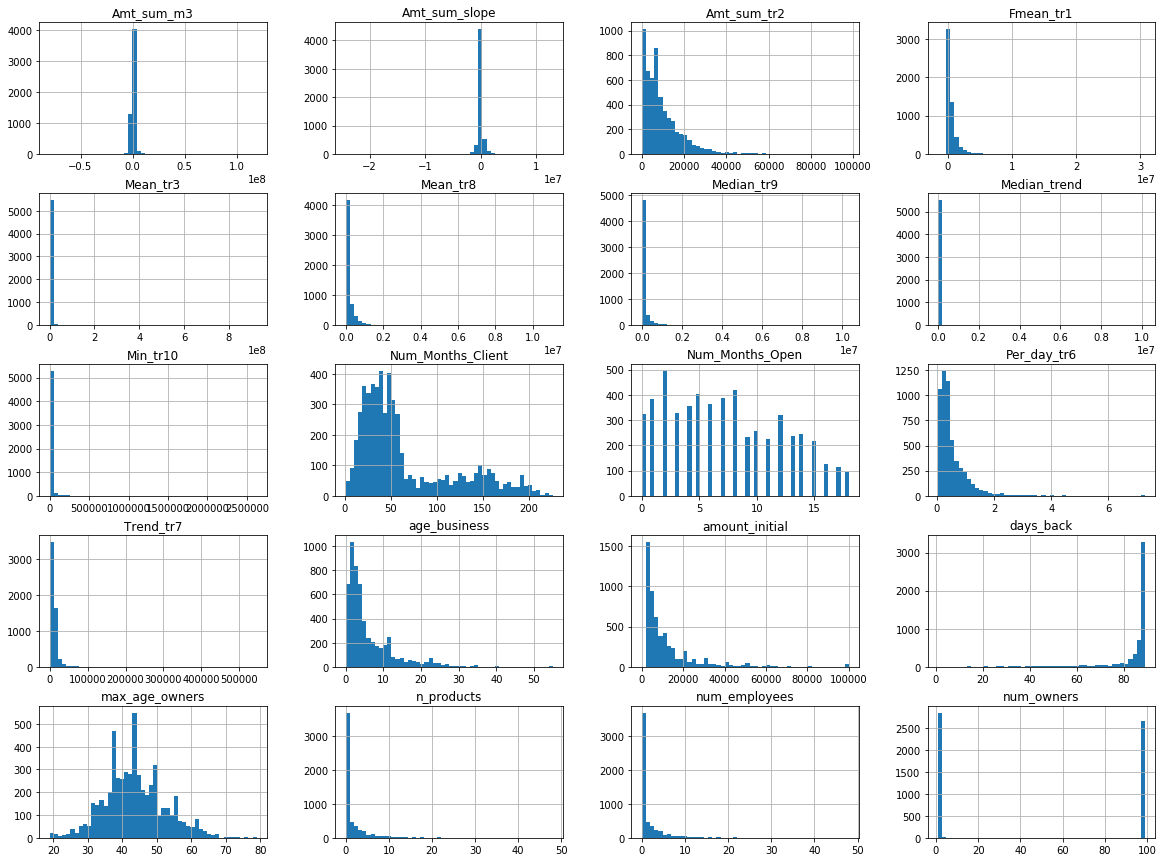

In [46]:
datos_num.hist(bins=50, figsize=(20,15))
plt.show()

__Matriz de correlación__

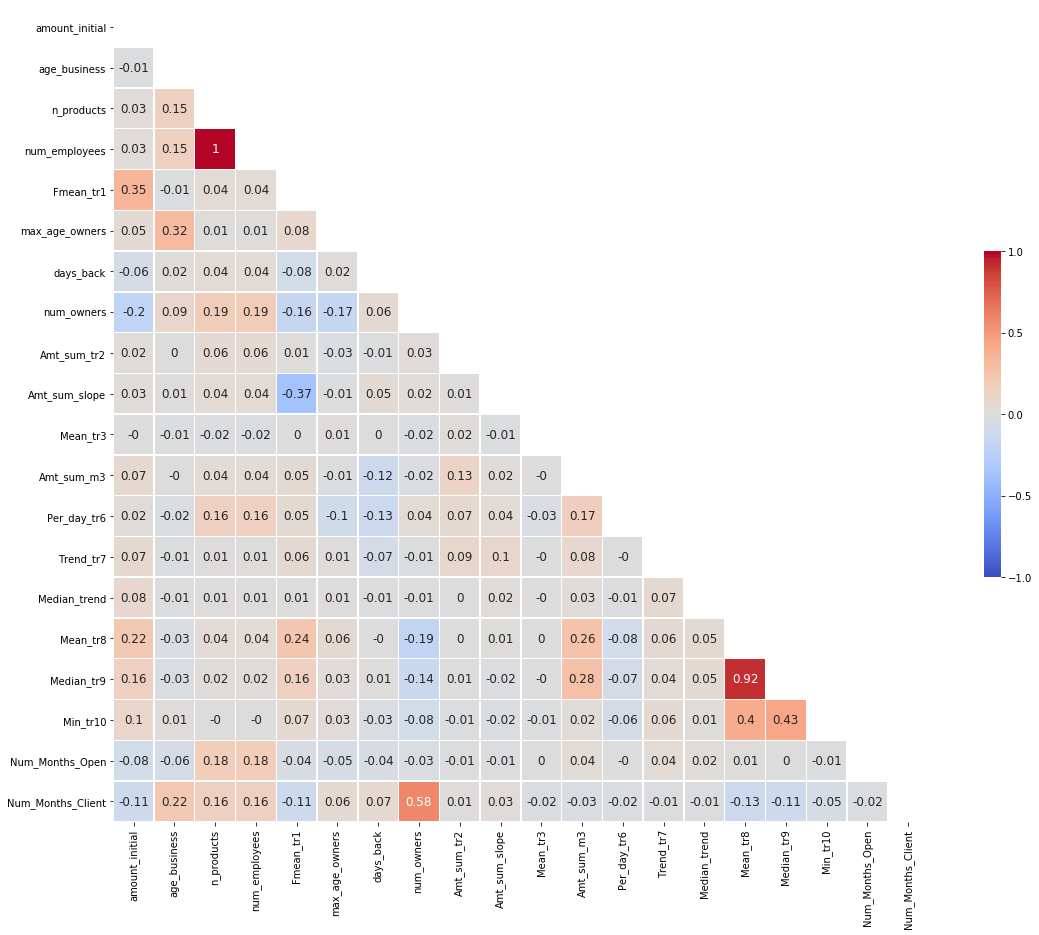

In [47]:
corr = round(datos_num[datos_num.columns[:]].corr(), 2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, 
                      square = True,
                      mask = mask,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Observamos que hay dos pares de variables muy correlacionadas entre ellas:

- Median_tr9 y Mean_tr8: 0.92
- num_employees y n_products: 1

Por ello, se decide eliminar una de las variables de cada par. Se elimina la variable que más valores ausentes tenga en cada caso: n_products y Mean_tr8.

In [48]:
## Eliminamos las variables que están altamente correlacionadas con otras
datos_num.pop('n_products')
datos_num.pop('Mean_tr8')

140      52944.0
141      21410.0
142      50925.0
143      82756.0
144      41875.0
          ...   
8545    100931.0
8549    100931.0
8550    100931.0
8552    100931.0
8553    100931.0
Name: Mean_tr8, Length: 5537, dtype: float64

__Escalar numéricas__

Se realiza una estandarización de las variables numéricas mediante el método de Robust Scaler.

In [49]:
scaler = preprocessing.RobustScaler()
num_scaled = scaler.fit_transform(datos_num)
num_scaled = pd.DataFrame(num_scaled, columns = datos_num.columns)

In [50]:
num_scaled.index = datos_num.index
num_scaled

,amount_initial,age_business,num_employees,Fmean_tr1,max_age_owners,days_back,num_owners,Amt_sum_tr2,Amt_sum_slope,Mean_tr3,Amt_sum_m3,Per_day_tr6,Trend_tr7,Median_trend,Median_tr9,Min_tr10,Num_Months_Open,Num_Months_Client
140,-0.029635,1.833333,0.0,-0.042080,-0.636364,0.00,0.989796,-0.189305,-0.021264,216.356915,-0.372458,0.717163,-0.729077,0.302811,-0.406754,-0.177225,1.375,2.619048
141,0.118542,-0.333333,0.0,-0.210601,-0.272727,-8.25,0.989796,3.695252,-0.396301,75.028754,0.129204,-0.268597,-0.133614,-0.051561,-0.388594,-0.171077,1.375,2.603175
142,-0.079028,0.000000,0.0,0.715555,-0.636364,-6.25,0.989796,0.052474,0.771483,1.824738,1.040138,0.274309,3.019677,0.645284,-0.339227,-0.155841,1.375,2.539683
143,0.365504,-0.333333,5.0,-0.520759,-0.818182,0.00,0.989796,-0.009795,-0.599275,1.184070,3.162107,0.712807,5.751761,0.031385,-0.372580,-0.179096,1.375,2.238095
144,-0.325990,0.000000,0.0,-0.563639,-0.818182,-3.75,0.989796,-0.480760,0.108636,0.000000,-0.117742,-0.631674,1.948015,4.086739,-0.066031,3.154237,1.375,1.825397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,0.365504,1.000000,0.0,0.000000,-0.181818,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500,1.238095
8549,-0.079028,0.000000,0.0,0.000000,1.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625,0.666667
8550,-0.128420,0.166667,0.0,0.000000,0.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500,-0.523810
8552,1.768251,1.000000,0.0,0.000000,0.454545,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625,0.968254


### Estudiamos variables categóricas

In [51]:
datos_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5537 entries, 140 to 8553
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SECTOR             5537 non-null   object
 1   admin_type         5537 non-null   object
 2   laboral_status     5537 non-null   object
 3   ROA_dicom          5537 non-null   object
 4   n_products_dicom   5537 non-null   object
 5   n_employees_dicom  5537 non-null   object
dtypes: object(6)
memory usage: 302.8+ KB


__Estudio estadístico__

In [52]:
datos_cat.describe().T

,count,unique,top,freq
SECTOR,5537,34,1031,899
admin_type,5537,5,1000,2423
laboral_status,5537,6,1,2878
ROA_dicom,5537,2,0,4663
n_products_dicom,5537,2,0,3701
n_employees_dicom,5537,2,0,3701


__Distribución de las variables y comparación con target__

Graficamos la distribución de los valores únicos. Además, veremos como se distribuye el target en cada categoría de cada variable, de forma que intentaremos poder aglutinar categorías para reducir el número de las mismas cuando se pueda.

___Sector___

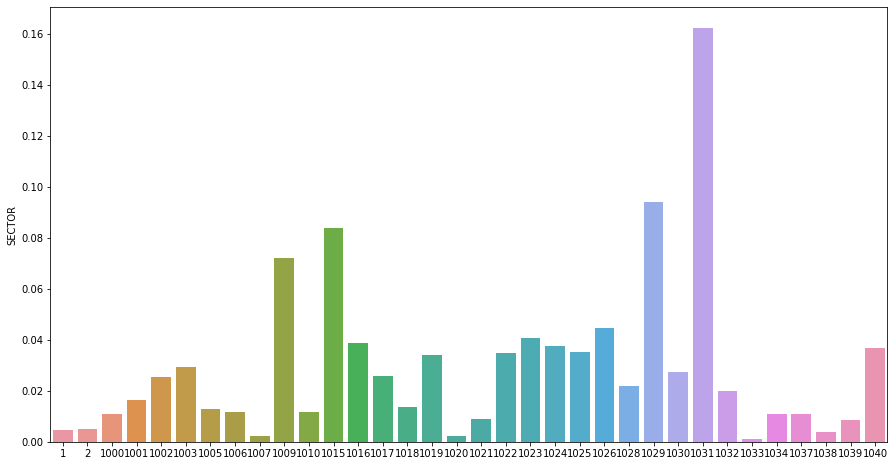

In [53]:
plt.figure(figsize = (15,8))
sns.barplot(datos_cat.SECTOR.unique(), datos_cat.SECTOR.value_counts(normalize = True))

In [54]:
sector = pd.DataFrame(datos.groupby('SECTOR')['Target'].value_counts(normalize = True))
sector

Target
SECTOR Target          
1      0       0.986667
       1       0.013333
2      0       1.000000
1000   0       1.000000
1001   0       0.910569
...                 ...
1038   0       0.576923
       1       0.423077
1039   0       1.000000
1040   0       0.956044
       1       0.043956

[61 rows x 1 columns]

Como podemos observar, existen categorías en el que el 100% de los casos son 0 (buenos). Por ello, se decide que todas estas categorías se agrupen en una llamada 99  para reducir el número de clases dentro de la variable. 

In [55]:
sector_0 = list(sector[sector['Target'] == 1].index.get_level_values('SECTOR'))
sector_0

[2, 1000, 1010, 1032, 1033, 1037, 1039]

In [56]:
for i in sector_0:
    datos_cat.SECTOR = np.where(datos_cat.SECTOR == i, 99, datos_cat.SECTOR.values)

C:\Users\migue\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


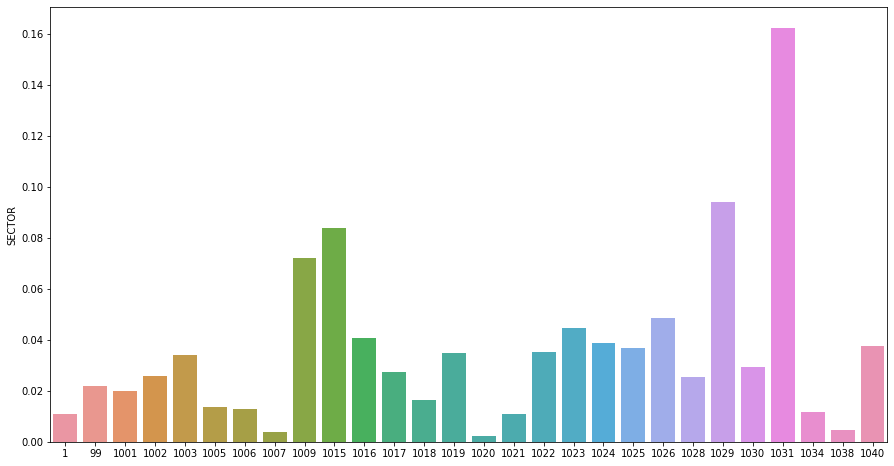

In [57]:
plt.figure(figsize = (15,8))
sns.barplot(datos_cat.SECTOR.unique(), datos_cat.SECTOR.value_counts(normalize = True))

Como se puede ver en el gráfico, el número de clases ha disminuido y conseguimos facilitar el modelo. 

___Admin type___

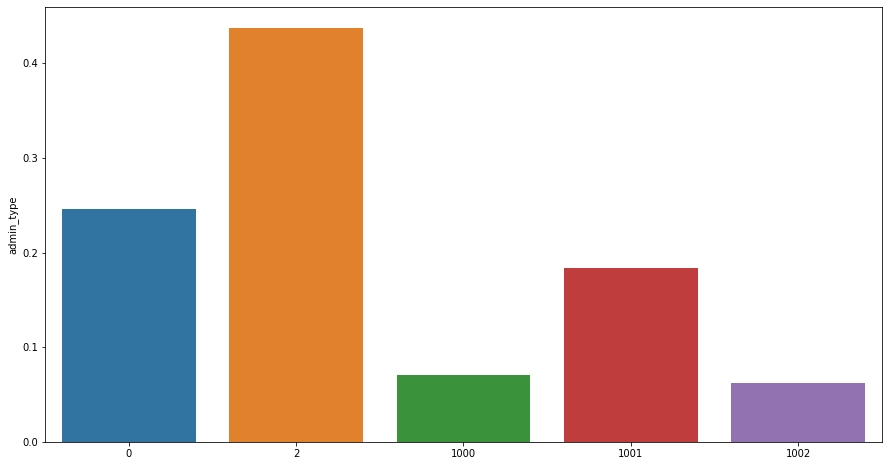

In [58]:
plt.figure(figsize = (15,8))
sns.barplot(datos_cat.admin_type.unique(), datos_cat.admin_type.value_counts(normalize = True))

In [59]:
datos.groupby('admin_type')['Target'].value_counts(normalize = True)

admin_type  Target
0           0         0.937070
            1         0.062930
2           0         0.957384
            1         0.042616
1000        0         0.878663
            1         0.121337
1001        0         0.923664
            1         0.076336
1002        0         0.880466
            1         0.119534
Name: Target, dtype: float64

Todas las clases de esta variable tienen porcentajes diferentes sobre el target, así que se mantiene.

___Laboral status___

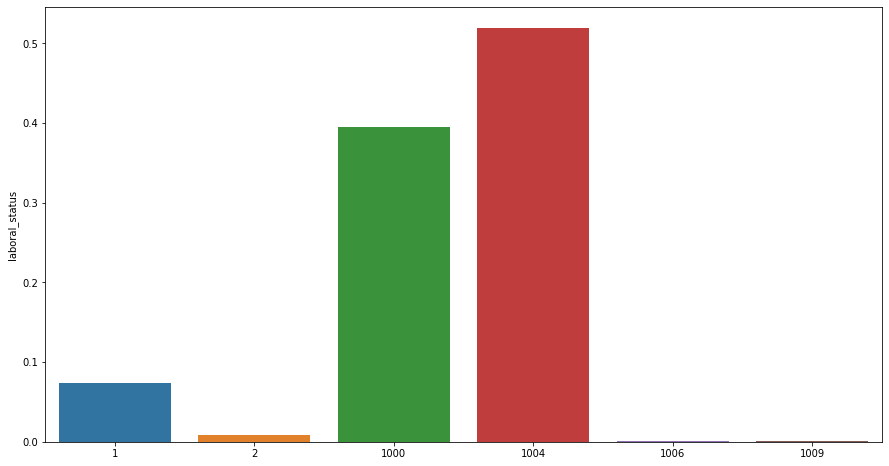

In [60]:
plt.figure(figsize = (15,8))
sns.barplot(datos_cat.laboral_status.unique(), datos_cat.laboral_status.value_counts(normalize = True))

In [61]:
datos.groupby('laboral_status')['Target'].value_counts(normalize = False)

laboral_status  Target
1               0         2549
                1          329
2               0            7
1000            0          394
                1           18
1004            0         2052
                1          138
1006            0           44
                1            2
1009            0            4
Name: Target, dtype: int64

Al igual que en la variable SECTOR, como en tres clases hay pocos casos y ninguno de ellos es 'malo', se deciden agrupar en una nueva clase llamada 99. 

In [62]:
datos_cat['laboral_status'] = np.where((datos_cat.laboral_status == 2) | (datos_cat.laboral_status == 1009) |
                                        (datos_cat.laboral_status == 1006), 99, datos_cat.laboral_status.values)

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


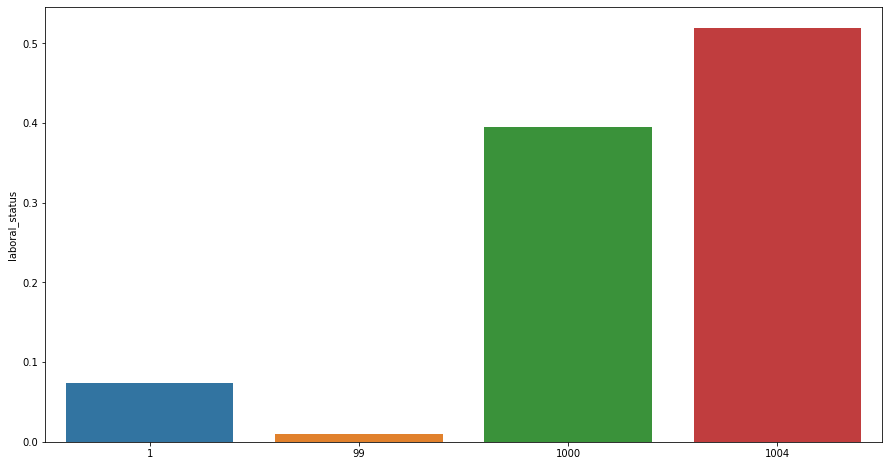

In [63]:
plt.figure(figsize = (15,8))
sns.barplot(datos_cat.laboral_status.unique(), datos_cat.laboral_status.value_counts(normalize = True))

___Dicotómicas___

In [64]:
datos.groupby(['Target', 'ROA_dicom']).size()

Target  ROA_dicom
0       0            4281
        1             769
1       0             382
        1             105
dtype: int64

In [65]:
datos.groupby(['Target', 'n_products_dicom']).size()

Target  n_products_dicom
0       0                   3388
        1                   1662
1       0                    313
        1                    174
dtype: int64

In [66]:
datos.groupby(['Target', 'n_employees_dicom']).size()

Target  n_employees_dicom
0       0                    3388
        1                    1662
1       0                     313
        1                     174
dtype: int64

# PCA

Se ha realizado un análisis PCA para reducir el número de variables. Un análisis PCA o _Análisis de Componentes Principales_ es una técnica utilizada para describir un conjunto de variables en términos de nuevas ariables no correlacionadas. La idea es reducir la dimensión, manteniendo el mayo porcentaje de varianza explicada. 

Este análisis PCA se ha llevado a cabo sobre las variables numéricas que contenían en su nombre 'tr'. Como no estaba claro a qué hacían referencia, se ha considerado que podrían tener relación entre ellas y, por tanto, tendría sentido reducir la dimensión y, así, la complejidad del modelo. 

In [67]:
pca_variables = num_scaled.loc[:,['Fmean_tr1', 'Amt_sum_tr2', 'Mean_tr3', 'Trend_tr7', 'Median_tr9', 'Min_tr10']]

In [68]:
pca = PCA()
num_scaled_pca = pca.fit_transform(pca_variables)

In [69]:
# porcentaje de varianza explicada según el número de componentes
explained_variance = pca.explained_variance_ratio_

Como se puede ver en el gráfico y, más adelante, en la tabla que muestra el porcentaje de varianza explicada, reduciendo la dimensión a un componente mantenemos un 99% de al varianza explicada. Debido a ello, nos quedamos con un componente y eliminamos las variables originales.

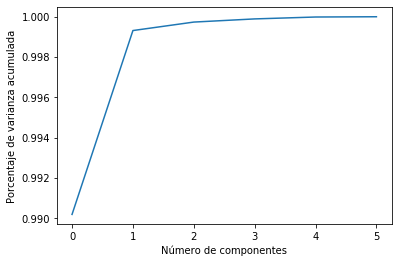

In [70]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Porcentaje de varianza acumulada');

In [71]:
explained_variance_df = pd.DataFrame(explained_variance, columns=['Porcentaje de varianza acumulada'])
explained_variance_df.head(6)

,Porcentaje de varianza acumulada
0,0.990190
1,0.009125
2,0.000420
3,0.000157
4,0.000094
5,0.000013


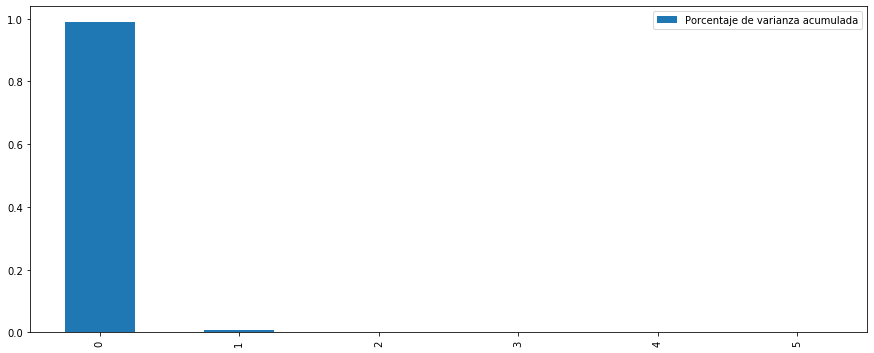

In [72]:
figura, ax1 = plt.subplots(1,  figsize = (15,6))
explained_variance_df.plot(ax=ax1, kind = 'bar')

In [73]:
# 1 componente
explained_variance_df.loc[0,].sum()

0.9901898202713321

Realizamos el PCA para un único componente

In [74]:
pca = PCA(n_components=1)
num_scaled_pca = pca.fit_transform(pca_variables)

In [75]:
num_scaled_pca = pd.DataFrame(num_scaled_pca, columns = ['Component_1'])

In [76]:
num_scaled_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5537 entries, 0 to 5536
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Component_1  5537 non-null   float64
dtypes: float64(1)
memory usage: 43.4 KB


In [77]:
num_scaled_pca.index = num_scaled.index
num_scaled_pca.head()

,Component_1
140,201.235203
141,59.907280
142,-13.297063
143,-13.937903
144,-15.124918


## Base de datos final

Combinamos finalmente las varibles numéricas escaladas con las categóricas, eliminamos las estudiadas en el PCA y añadimos el componente resultante.

In [78]:
# concatenating for the random forest
datos_final_obs2 = pd.concat([num_scaled, datos_cat], axis = 1)
datos_final_obs2['Target'] = datos['Target']
datos_final_obs2

,amount_initial,age_business,num_employees,Fmean_tr1,max_age_owners,days_back,num_owners,Amt_sum_tr2,Amt_sum_slope,Mean_tr3,Amt_sum_m3,Per_day_tr6,Trend_tr7,Median_trend,Median_tr9,Min_tr10,Num_Months_Open,Num_Months_Client,SECTOR,admin_type,laboral_status,ROA_dicom,n_products_dicom,n_employees_dicom,Target
140,-0.029635,1.833333,0.0,-0.042080,-0.636364,0.00,0.989796,-0.189305,-0.021264,216.356915,-0.372458,0.717163,-0.729077,0.302811,-0.406754,-0.177225,1.375,2.619048,1031,2,1004,0,0,0,0
141,0.118542,-0.333333,0.0,-0.210601,-0.272727,-8.25,0.989796,3.695252,-0.396301,75.028754,0.129204,-0.268597,-0.133614,-0.051561,-0.388594,-0.171077,1.375,2.603175,1029,2,1004,0,0,0,0
142,-0.079028,0.000000,0.0,0.715555,-0.636364,-6.25,0.989796,0.052474,0.771483,1.824738,1.040138,0.274309,3.019677,0.645284,-0.339227,-0.155841,1.375,2.539683,1015,2,1004,0,0,0,0
143,0.365504,-0.333333,5.0,-0.520759,-0.818182,0.00,0.989796,-0.009795,-0.599275,1.184070,3.162107,0.712807,5.751761,0.031385,-0.372580,-0.179096,1.375,2.238095,1009,0,1000,0,1,1,0
144,-0.325990,0.000000,0.0,-0.563639,-0.818182,-3.75,0.989796,-0.480760,0.108636,0.000000,-0.117742,-0.631674,1.948015,4.086739,-0.066031,3.154237,1.375,1.825397,1026,2,1000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,0.365504,1.000000,0.0,0.000000,-0.181818,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500,1.238095,1024,2,1004,0,0,0,0
8549,-0.079028,0.000000,0.0,0.000000,1.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625,0.666667,1001,0,1004,0,0,0,0
8550,-0.128420,0.166667,0.0,0.000000,0.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500,-0.523810,1003,1002,1004,0,0,0,0
8552,1.768251,1.000000,0.0,0.000000,0.454545,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625,0.968254,99,0,1000,0,0,0,0


In [79]:
datos_final_obs2.drop(pca_variables.columns, axis=1, inplace=True)

In [80]:
datos_final_obs2 = pd.concat([num_scaled_pca, datos_final_obs2], axis = 1)
datos_final_obs2

,Component_1,amount_initial,age_business,num_employees,max_age_owners,days_back,num_owners,Amt_sum_slope,Amt_sum_m3,Per_day_tr6,Median_trend,Num_Months_Open,Num_Months_Client,SECTOR,admin_type,laboral_status,ROA_dicom,n_products_dicom,n_employees_dicom,Target
140,201.235203,-0.029635,1.833333,0.0,-0.636364,0.00,0.989796,-0.021264,-0.372458,0.717163,0.302811,1.375,2.619048,1031,2,1004,0,0,0,0
141,59.907280,0.118542,-0.333333,0.0,-0.272727,-8.25,0.989796,-0.396301,0.129204,-0.268597,-0.051561,1.375,2.603175,1029,2,1004,0,0,0,0
142,-13.297063,-0.079028,0.000000,0.0,-0.636364,-6.25,0.989796,0.771483,1.040138,0.274309,0.645284,1.375,2.539683,1015,2,1004,0,0,0,0
143,-13.937903,0.365504,-0.333333,5.0,-0.818182,0.00,0.989796,-0.599275,3.162107,0.712807,0.031385,1.375,2.238095,1009,0,1000,0,1,1,0
144,-15.124918,-0.325990,0.000000,0.0,-0.818182,-3.75,0.989796,0.108636,-0.117742,-0.631674,4.086739,1.375,1.825397,1026,2,1000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,-15.121823,0.365504,1.000000,0.0,-0.181818,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,-0.500,1.238095,1024,2,1004,0,0,0,0
8549,-15.121823,-0.079028,0.000000,0.0,1.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,-0.625,0.666667,1001,0,1004,0,0,0,0
8550,-15.121823,-0.128420,0.166667,0.0,0.000000,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,-0.500,-0.523810,1003,1002,1004,0,0,0,0
8552,-15.121823,1.768251,1.000000,0.0,0.454545,0.00,0.989796,0.000000,0.000000,0.000000,0.000000,-0.625,0.968254,99,0,1000,0,0,0,0


La base de datos resultante contiene 20 variables y 5537 registros.

## División en train y test

En primer lugar, separamos la variable endógena (Target) de las exógenas con el objetivo de dividir la muestra en train y test. Se selecciona una muestra de entrenamiento del 80% y de prueba del 20% y no se hace validación debido al reducido tamaño de la muestra.

In [81]:
X_rf = datos_final_obs2.loc[:, datos_final_obs2.columns != 'Target']
Y_rf = datos_final_obs2.loc[:, 'Target']

In [82]:
Y_rf.value_counts(normalize=True)

0    0.912046
1    0.087954
Name: Target, dtype: float64

In [83]:
X_train, X_test, Y_train, Y_test  = train_test_split(X_rf, Y_rf, test_size = 0.2, random_state = 42)

## Tratamiento de desequilibrio (SmoteTomek)

Como en la mayoría de las muestras para modelos de riesgo, los datos en cuestión están altamente desequilibradps, es, decir, que la proporción entre buenos y malos no es 1-1. En este caso, la proporción de malos es de un 8,79% frente a un 91,2% de buensos. 

Para evitar la presencia de sesgo hacia la muestra de mayor representación (buenos) (ya que la función de pérdida trata de optimizar valores como la tasa de error, sin considerar la distribución de la muestra) se decide tratar este desquilibrio y tratar de balancear la muestra de desarrollo. La técnica seleccionada para hacer esto es `SMOTETomek`.

El SmoteTomek es una combinación de las técnicas de SMOTE y TomeLinks que realiza primero un oversampling con datos sintéticos y posteriormente un undersampling. Una característica de esta técnica es que quilibra la base de datos hasta obtener una relación de buenos y malos 50%-50%.

In [84]:
%%time
X_train, Y_train = SMOTETomek(random_state=42,
                                      n_jobs=-1).fit_resample(X_train, Y_train)

Wall time: 570 ms


In [85]:
columnas = datos_final_obs2.loc[:, datos_final_obs2.columns != 'Target']
columnas = columnas.columns

In [86]:
Y_train = pd.DataFrame(Y_train, columns = ['Target'])
X_train = pd.DataFrame(X_train, columns = columnas)

In [87]:
Y_train['Target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: Target, dtype: float64

## Feature Importance (Random Forest)

Para la selección de las variables más importantes, se decide calcular el valor predictivo de cada una mediante un Random Forest. Se selecciona este modelo por dos razones principales:
* Comodidad: No es necesario convertir las variables categóricas en dummies (menor complejidad para el modelo)
* Es un modelo muy utilzado en este ámbito

A continuación, creamos una función para seleccionar las variables con mayor importancia y ejecutamos el clasificador. Se considerarán como relevantes todas las variables que tengan una importancia mayor a 0,02.

In [88]:
def features_importance(coeficients, features):
    data = {'Features':features.index, 'Coeficients':coeficients} 
    coef = pd.DataFrame(data).sort_values(by=['Coeficients'], ascending=False)
    fig, ax = plt.subplots(figsize=(12,10))
    coef_plot = sns.barplot(coef['Features'],coef['Coeficients'])
    coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation=40, ha="right");

In [89]:
%%time
param_test1 = {
    'max_depth' : [4,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'class_weight' : ({0:80,1:20},{0:70,1:30},{0:50,1:50})
 }
gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(100), 
                               param_grid = param_test1, scoring='recall_weighted',n_jobs=-1, iid=False, cv=5)
gsearch_RandomForest.fit(X_train, Y_train)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Wall time: 34.9 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [90]:
%%time
gsearch_RandomForest2 = gsearch_RandomForest.best_estimator_
gsearch_RandomForest2.fit(X_train, Y_train)

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Wall time: 1.82 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 50, 1: 50}, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [91]:
importance = pd.DataFrame(gsearch_RandomForest2.feature_importances_, X_train.columns, columns = ['Importance'])
importance_10 = importance[importance['Importance'] > 0.02].sort_values(by='Importance', ascending=False).head(20)
importance_10

,Importance
Num_Months_Open,0.218829
Num_Months_Client,0.118941
age_business,0.078295
SECTOR,0.064575
amount_initial,0.059706
days_back,0.056066
max_age_owners,0.046867
admin_type,0.046233
n_employees_dicom,0.038683
Per_day_tr6,0.035055


El modelo de Random Forest establece que hay 17 variables que tienen un feauture importance superior a 0.02. Estas variables se grafican a continuación y son las que se seleccionarán para realizar el modelo final. Entre estas variables, observamos que:
* las dos con mayor importancia son las que hemos creado en base a la fecha desde que es cliente y la fecha en la que se concedió el crédito. 
* se ha cosiderado relevante la componente del PCA 
* las tres variables dicotómicas que hemos generado en base a las variables categóricas que tenían demasiados valores nulos son relevantes
* la variable SECTOR, que también habíamos modificado, es la cuarta más relevante



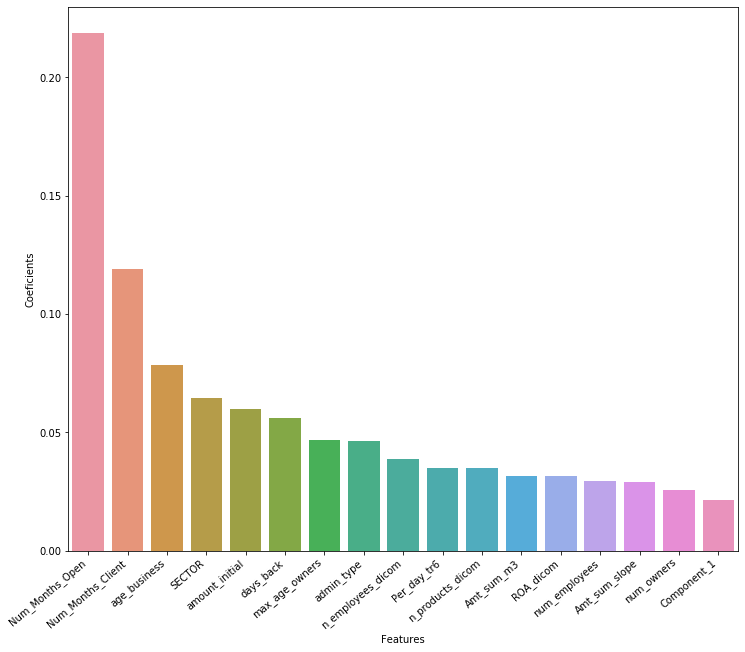

In [92]:
features_importance(importance_10['Importance'], importance_10)

In [93]:
len(importance_10)

17

In [94]:
importance_10.index

Index(['Num_Months_Open', 'Num_Months_Client', 'age_business', 'SECTOR',
       'amount_initial', 'days_back', 'max_age_owners', 'admin_type',
       'n_employees_dicom', 'Per_day_tr6', 'n_products_dicom', 'Amt_sum_m3',
       'ROA_dicom', 'num_employees', 'Amt_sum_slope', 'num_owners',
       'Component_1'],
      dtype='object')

Generamos el dataframe final con las variables relevantes para la muestra de entrenamiento para poder comenzar a ejecutar modelos.

In [95]:
X_train_final = X_train.loc[:, importance_10.index]
X_test = X_test.loc[:, importance_10.index]

In [96]:
X_train_final

,Num_Months_Open,Num_Months_Client,age_business,SECTOR,amount_initial,days_back,max_age_owners,admin_type,n_employees_dicom,Per_day_tr6,n_products_dicom,Amt_sum_m3,ROA_dicom,num_employees,Amt_sum_slope,num_owners,Component_1
0,0.375000,-0.349206,-0.333333,1019,-0.296355,-4.000000,-0.636364,1000,0,-0.408597,0,0.776785,0,0.0,0.539746,-0.010204,-7.617071
1,-0.375000,1.365079,1.500000,1022,0.266719,0.250000,1.000000,0,0,0.424506,0,1.009092,0,0.0,0.943203,0.989796,-14.974188
2,0.125000,1.587302,-0.333333,1031,0.938161,0.250000,0.727273,2,0,1.779735,0,-0.071397,0,0.0,1.003038,0.989796,-15.333132
3,0.625000,-0.015873,-0.333333,1031,-0.325990,0.250000,-0.636364,0,0,0.724648,0,0.473628,0,0.0,0.491593,0.989796,-15.184163
4,0.000000,0.492063,0.000000,1023,-0.325990,-0.250000,-0.636364,2,1,1.809475,1,0.581930,0,2.0,0.686506,0.989796,-14.366087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8049,0.180844,-0.077398,-0.239674,1023.44,0.209639,0.109511,-0.681422,1000,0,-0.003809,0,-0.614484,0,0.0,-1.021644,-0.010204,-15.297858
8050,0.032605,2.174860,0.000000,1015.34,-0.249271,-17.955179,0.036070,1.31521,0,0.451845,0,0.032386,0,0.0,-0.001228,0.989796,-15.122105
8051,0.260214,-0.425799,-0.500000,1011.62,0.447467,-5.804906,0.099359,1000,0,1.308455,0,179.142313,0,0.0,2.455013,-0.010204,-15.368585
8052,-0.250000,0.198866,1.029637,1016,0.674865,0.227162,-0.157348,1000,0,-0.179267,0,1.725351,0,0.0,2.966655,-0.010204,-14.919178


## Modelos

Se han probado una serie de modelos diferentes con la intención de seleccionar el que mejor prediga, teniendo en cuenta las características de los datos y las variables finales. Para la selección del mejor modelo, se comparan métricas como el f1-score, recall (principalmente) y precisión; matrices de confusión y curva ROC para cada modelo. Los modelos ejecutados son: 
* Support Vector Machine (SVM)
* Logística
* Gradient Boosting Classifier
* Adaboost
*  Random Forest

__Funciones para los modelos__

A continuación, generamos una serie de funciones a aplicar en cada modelo: 
* _save_models_: nos permite guardar cada modelo con pickle para después importarlos sin necesidad de volver a ejecutarlos
* _conf_matrix_: generar la matriz de confusión de cada modelo
* _show_results_: mostrar los resultados
* _show_ROC_: graficar la curva ROC de cada modelo
* _load_models_: cargar modelos guardados con pickle

In [97]:
def save_models(filename, model):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [98]:
def conf_matrix(Y_test, Y_pred):
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred)
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g')
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

In [99]:
def show_results(test, predict):
    conf_matrix(test, predict)
    print(classification_report(test,predict))

In [100]:
def show_ROC(predict):
    metrics.plot_roc_curve(predict, X_test, Y_test)
    plt.show()                     
    print("Score: ", predict.score(X_test, Y_test))

In [101]:
def load_models(filename):
    with open(filename, 'rb') as file:
        return(pickle.load(file))

### Support Vector Machine

El primero modelo que ejecutamos es el Support Vector Machine, donde se decide hacer un grid search para seleccionar los parámetros optimos. 

In [102]:
%%time
parametros_support = {'C': [1, 5, 10], 'kernel': ('linear', 'rbf')}
support_vector = GridSearchCV(estimator = SVC(max_iter = 1000),
             param_grid = parametros_support , scoring = 'roc_auc', n_jobs = -1, iid = False, cv = 3)
support_vector.fit(X_train_final, Y_train)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 3.09 s


C:\Users\migue\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=1000,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [103]:
# selección de los mejores parámetros para el modelo
support_vector.best_estimator_ 

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
%%time
best_SVC = support_vector.best_estimator_
best_SVC.fit(X_train_final, Y_train)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 1.21 s


C:\Users\migue\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

None
              precision    recall  f1-score   support

           0       0.97      0.06      0.12      1003
           1       0.10      0.98      0.18       105

    accuracy                           0.15      1108
   macro avg       0.53      0.52      0.15      1108
weighted avg       0.89      0.15      0.12      1108



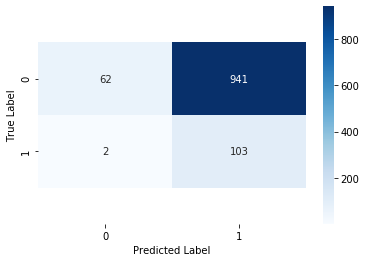

In [105]:
# confusion matrix: SVC
prediccion_SVC_test = best_SVC.predict(X_test)
print(conf_matrix(Y_test, prediccion_SVC_test))
print(classification_report(Y_test, prediccion_SVC_test))

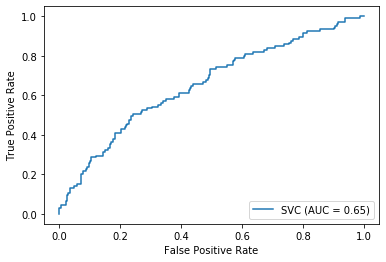

Score:  0.14891696750902528


In [106]:
show_ROC(best_SVC)

### Logística

In [107]:
%%time
logit_loan = LogisticRegression(random_state=40, solver="saga", penalty="l1", class_weight={0:0.7,1:0.3}, C=1.0, max_iter=500)
logit_loan.fit(X_train_final, Y_train)
logit_probs = logit_loan.predict_proba(X_train_final)
logit_scores = logit_probs[:,1]
pred_logit = logit_loan.predict(X_test)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 2.78 s


C:\Users\migue\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1003
           1       0.04      0.01      0.02       105

    accuracy                           0.89      1108
   macro avg       0.47      0.49      0.48      1108
weighted avg       0.82      0.89      0.85      1108



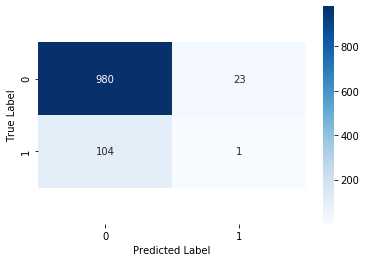

In [108]:
conf_matrix(Y_test, pred_logit)
print(classification_report(Y_test, pred_logit))

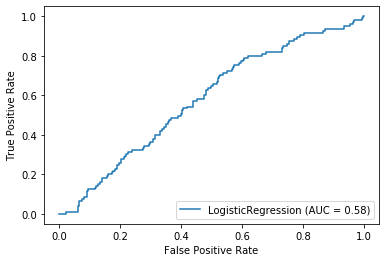

Score:  0.8853790613718412


In [109]:
# ROC curve
show_ROC(logit_loan)

### Gradient Boosting Classifier

In [110]:
%%time
seed = 7
num_trees = 300
kfold = model_selection.KFold(n_splits=3, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train_final, Y_train, cv=kfold)

model.fit(X_train_final, Y_train)
model.score(X_test,Y_test)

print(results.mean())

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

0.9174327300849875
Wall time: 38.9 s


In [111]:
save_models('./GBC', model)

In [112]:
model = load_models('./GBC')

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1003
           1       0.53      0.31      0.40       105

    accuracy                           0.91      1108
   macro avg       0.73      0.64      0.67      1108
weighted avg       0.89      0.91      0.90      1108



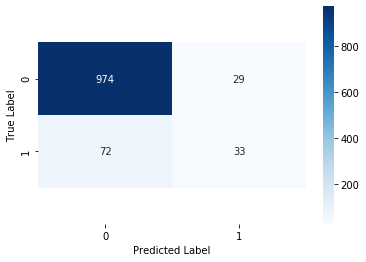

In [113]:
pred_GBC = model.predict(X_test)
conf_matrix(Y_test, pred_GBC)
print(classification_report(Y_test, pred_GBC))

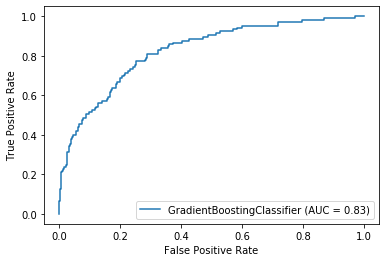

Score:  0.9088447653429603


In [114]:
show_ROC(model)

### Adaboost

In [115]:
%%time
seed = 7
kfold2 = model_selection.KFold(n_splits=3, random_state=seed)
adaboost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 2, random_state = 0),
    300,
    learning_rate = 1,
    random_state = 0
)

results_adaboost = model_selection.cross_val_score(adaboost, X_train_final, Y_train, cv=kfold2)

adaboost.fit(X_train_final, Y_train)
adaboost.score(X_test,Y_test)

print(results_adaboost.mean())

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

0.9373009331338849
Wall time: 33.6 s


In [116]:
save_models('./adaboost', adaboost)

In [117]:
adaboost = load_models('./adaboost')

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1003
           1       0.53      0.31      0.40       105

    accuracy                           0.91      1108
   macro avg       0.73      0.64      0.67      1108
weighted avg       0.89      0.91      0.90      1108



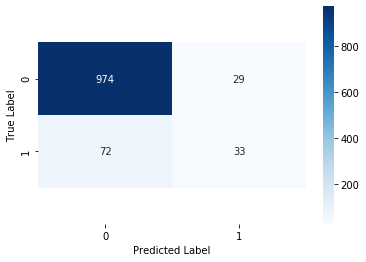

In [118]:
pred_adaboost = adaboost.predict(X_test)
conf_matrix(Y_test, pred_adaboost)
print(classification_report(Y_test, pred_adaboost))

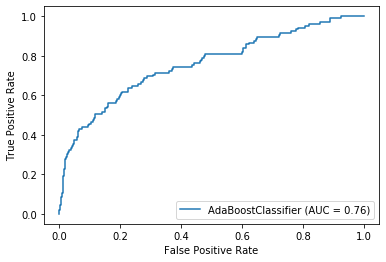

Score:  0.9088447653429603


In [119]:
show_ROC(adaboost)

### Random Forest

In [120]:
%%time
param_test1 = {
    'max_depth' : [4,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'class_weight' : ({0:80,1:20},{0:70,1:30},{0:50,1:50})
 }
gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(300), 
                               param_grid = param_test1, scoring='recall_weighted',n_jobs=-1, iid=False, cv=5)
gsearch_RandomForest.fit(X_train_final, Y_train)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Wall time: 1min 32s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False,
                                              rando

In [121]:
%%time
gsearch_RandomForest2 = gsearch_RandomForest.best_estimator_
gsearch_RandomForest2.fit(X_train_final, Y_train)

gsearch_RandomForest2.score(X_test,Y_test)

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Wall time: 3.26 s


0.8862815884476535

In [122]:
importance = pd.DataFrame(gsearch_RandomForest2.feature_importances_, X_train_final.columns, columns = ['Importance'])
importance = importance.sort_values(by='Importance', ascending=False).head(20)
importance

,Importance
Num_Months_Open,0.222876
Num_Months_Client,0.121452
age_business,0.080180
SECTOR,0.064935
days_back,0.064630
amount_initial,0.063253
max_age_owners,0.053116
admin_type,0.050987
Per_day_tr6,0.037278
n_employees_dicom,0.035632


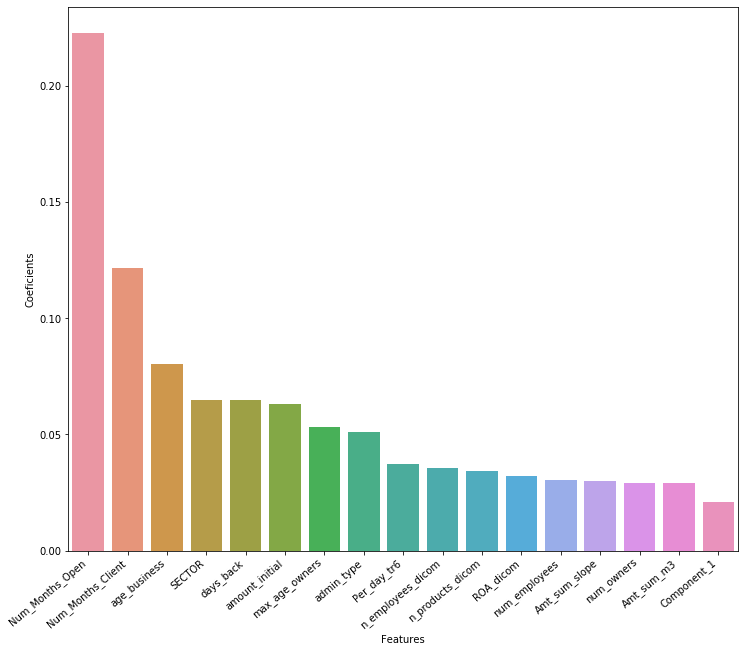

In [123]:
features_importance(importance['Importance'], importance)

In [124]:
save_models('./gsearch_RandomForest2', gsearch_RandomForest2)

__Matriz de confusión__

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1003
           1       0.42      0.51      0.46       105

    accuracy                           0.89      1108
   macro avg       0.68      0.72      0.70      1108
weighted avg       0.90      0.89      0.89      1108



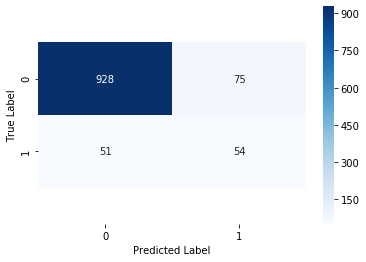

In [125]:
pred_gsearch_RandomForest2 = gsearch_RandomForest2.predict(X_test)
conf_matrix(Y_test, pred_gsearch_RandomForest2)
print(classification_report(Y_test, pred_gsearch_RandomForest2))

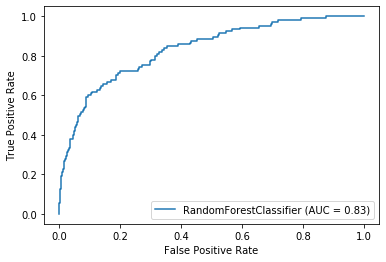

Score:  0.8862815884476535


In [126]:
show_ROC(gsearch_RandomForest2)

### Mejor modelo

__Explicación modelos:__

* __Support Vector Machine (SVM)__: Aunque la precisión a la hora de predecir los casos malos es muy alta (un 98%), la predicción general del modelo es de un 15%, ya que no predice casi ningún caso bueno. Viendo el f1-score, el valor es muy bajo para ambas clases, lo cual implica que o el accuracy o el recall son muy bajos. Es mal modelo (como se ve tabién en la matriz de confusión.
* __Logística__: Pasa algo similar que en el modelo SVM pero prediciendo principalmente clientes buenos, es decir, que no identifica ningún caso malo; consideramos que es el peor modelo porque, no solo tiene métricas muy malas en la predicción, sino que supone la mayor cantidad de costes según hemos establecido en la estrategia de negocio.
* __Gradient Boosting Classifier__: Contamos en este modelo con un accuracy de 91%, pero un recall sobre los casos malos de un 31%. Esto significa que se capta solo el 31% de los casos malos, lo cual nos parece insuficiente. 
* __Adaboost__: Al igual que el modelo anterior, el accuracy de este modelo es de un 91%, y el recall es también de un 31% para los casos malos. Sacamos la misma conclusión que en el caso anterior. 
* __Random Forest__: Obtenemos un recall sobre los casos malos de 0.51, de los 105 casos malos que hay en la parte de test el modelo identifica correctamente 51. Aunque la precisión descienda un poco en comparación con los dos modelos anteriores (88%), pierde precisión únicamente en los 0s (casos buenos), los costes de este error en la interpretación no son tan altos como en la contraria. Teniendo en cuenta el fuerte desequilibrio que había en la parte de train no es un mal modelo; además, obtenemos un AUC de 0.83. 

Concluímos que el mejor modelo para los datos imputados con las variables seleccionadas es el Random Forest.

#### Técnica de Validación: Bootstrapping

Debido a que la muestra de datos era reducida, no se creó una muestra de validación para los modelos aparte de la de test. Sin embargo, para comprobar que el accuracy obtenido con el modelo sobre la parte de test no difería en función de la muestra seleccionada aleatoriamente, se ha llevado a cabo un proceso de validación por Bootstrapping por cinco grupos sobre el modelo Random Forest (teniendo en cuenta toda la muestra). 

Para ello, realizamos el SmoteTomek de nuevo, esta vez sobre toda la muestra, y ejecutamos el modelo, aplicando como cross validation el método de Bootstrapping.

In [127]:
%%time
X_train_rf, Y_train_F = SMOTETomek(random_state=42,
                                      n_jobs=-1).fit_resample(X_rf, Y_rf)

Wall time: 410 ms


In [128]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [129]:
%%time
param_test1 = {
    'max_depth' : [4,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'class_weight' : ({0:80,1:20},{0:70,1:30},{0:50,1:50})
 }
gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(300), 
                               param_grid = param_test1, scoring='recall_weighted',n_jobs=-1, iid=False, cv=ss)
gsearch_RandomForest.fit(X_train_rf, Y_train_F)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 1min 24s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,...
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
         

In [130]:
%%time
gsearch_RandomForest3 = gsearch_RandomForest.best_estimator_
gsearch_RandomForest3.fit(X_train_rf, Y_train_F)

Wall time: 3.1 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 50, 1: 50}, criterion='gini',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [131]:
cross_val_score(gsearch_RandomForest3, X_train_rf, Y_train_F, cv = ss)

array([0.90199005, 0.90597015, 0.89502488, 0.90845771, 0.91442786])

Se puede observar que el accuracy en los cinco folds obtenidos por Bootstrapping para el Random Forest son muy similares entre ellos (rondan valores entre 89,5% y 91%) y no difieren con la muestra original de test (88%). Por tanto, nuestra muestra de test y de train era representativa de la muestra total de datos. 

## Cut off óptimo (matriz de costes)

Como se estableció en la definición del objetivo, consideramos que el banco pierde más dinero cuando se realiza un impago que cuando no se concede un crédito que realmente sí que se pagaría. Debido a esto, queremos establecer unos costes al modelo cuando falla los registros que son malos y los identifica como buenos que sean mayores que los identificados como malos y son buenos. 

Seleccionamos el modelo que se ha identificado como el mejor y se le aplican unos costes 5 veces mayor a los casos de falsos negativos que a los falsos positivos. 

In [132]:
# Guardo los resultados de la predicción en un array
Y_pred_prob = []
for i in range(0,len(gsearch_RandomForest2.predict_proba(X_test))):
    Y_pred_prob += [(gsearch_RandomForest2.predict_proba(X_test)[i][0])]

In [133]:
Y_pred_prob = np.array(Y_pred_prob)

In [134]:
%%time
# Searchgrid cut off
costes = []
for i in [i/100 for i in range(1,100)]:
    costes += [(confusion_matrix(Y_test, Y_pred_prob < i)*(np.array([[0,2],[10,0]]))).sum()]

Wall time: 230 ms


In [135]:
print("El coste mínimo en el test es {} y se ha producido con el cut-off en: {}".format(min(costes),[i/100 for i in range(1,100)][costes.index(min(costes))]) )

El coste mínimo en el test es 608 y se ha producido con el cut-off en: 0.53


Matriz de confusión final a partir del cut-off estimado con los costes:

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1003
           1       0.40      0.60      0.48       105

    accuracy                           0.88      1108
   macro avg       0.68      0.75      0.71      1108
weighted avg       0.90      0.88      0.89      1108



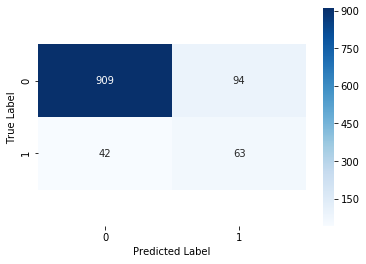

In [137]:
conf_matrix(Y_test, Y_pred_prob < 0.53)
print(classification_report(Y_test, Y_pred_prob < 0.53))

Obtenemos así que el mejor cut off es de 0.53. Es decir, que para los casos que tengan una probabilidad superior a 0.52 de ser considerados como malos serán considerados como tal.  Con este cut off se obtienen las siguientes métricas:

- Accuracy: __0.88__
- Recall de malos: __0.60__
- Verdaderos positivos: __63__
- Falsos positivos: __94__
- Falsos negativos: __42__

# Conclusiones

El objetivo del estudio era tratar de identificar, con la mayor precisión posible, los clientes que no vayan a pagar el préstamo concedido. 

Para obtener estas predicciones, en primer lugar, se ha seleccionado una de las 9 variables proporcionadas de impago a distintos periodos temporales (KGB population) para una ventana de comportamiento de 12 meses. El periodo seleccionado como identificador de cliente 'malo' fue el de impago durante 90 días, considerando que 30 y 60 días serían clientes indeterminados, para extraerlos así de la muestra. Se redujo también la muestra a los registros que hubiesen abierto una línea de crédito entre junio de 2016 y diciembre de 2017 (un año y medio). 

A continuación, se realizó un estudio exhaustivo de las variables para preparar los datos a estudiar con los modelos planteados (imputación de valores nulos, eliminación de variables, PCA, etc.). Tras la ingeniería de variables, la base de datos previa a la feature selection estaba formada por 20 variables. Con los datos ya equilibrados mediante la técnica de SMOTETomek, el método empleado para la selección de variables fue un Random Forest, donde se consideraron relevantes 17 de ellas (aplicado únicamente sobre la muestra de entrenamiento). 

Se han aplicado varios modelos distintos de predicción, desde los más sencillos (SVM, Logística), hasta métodos de ensemble de árboles (RF y GBC). Como era de esperar, uno de estos últimos dio el mejor resultado y se seleccionó como mejor modelo: un Random Forest con optimización de hiperparámetros mediante GridSearchCV.  

Tras aplicar una penalización mayor a los casos que este modelo identifica como buenos pero que realmente son malos (impagos), hemos visto aumentado el valor de recall para la identificación de estos clientes, llegando a un __60% de recall en identificación de malos__ y un __88% de accuracy__.

__Recomendaciones:__

* Se podría ampliar el estudio con una mayor muestra de datos para poder, por ejemplo, incluir muestra de validación 
* Se podría haber reducido más la muestra por el espacio temporal para que el porcentaje de bad rates no difiera tanto. El problema en este caso es que, al tener un número de casos tan reducido, la muestra puede estar sesgada y no ser representativa de la población total (overfitting).

## Bibliografía

Páginas web:
* https://getquipu.com/blog/que-es-el-roa-y-el-roe/
* https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 
* https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Libros:
* __Título:__ Feature Engineering for Machine Learning, Principles and Techniques for Data Scientists. __Autores:__ Alice Zheng & Amanda Casari. __Editorial:__ O'Reilly Media
*  __Título:__ Credit Risk Scorecards: Developinng and Implementing Intelligent Credit Scoring. __Autores:__ Naeem Siddiqi. __Editorial:__ John Wiley & Sons, Inc.